#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링 
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [324]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm 
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings('ignore')

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [2]:
data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
data = pd.read_csv(data_path)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [3]:
data = data.drop('subject', axis=1)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [4]:
is_dynamic = data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)
data['Activity_dynamic'] = is_dynamic
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


### - 'WALKING': 0,
### - 'WALKING_UPSTAIRS': 1,
### - 'WALKING_DOWNSTAIRS': 2,
### - 'LAYING': 3,
### - 'STANDING': 4,
### - 'SITTING': 5 

In [5]:
data['Activity'] = data['Activity'].map({'WALKING': 0,
                                         'WALKING_UPSTAIRS': 1,
                                         'WALKING_DOWNSTAIRS': 2,
                                         'LAYING': 3,
                                         'STANDING': 4,
                                         'SITTING': 5 })
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,4,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,3,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,4,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,2,1


In [6]:
X = data.drop(['Activity', 'Activity_dynamic'], axis=1)
y1 = data['Activity']
y2 = data['Activity_dynamic']

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
X_train, X_val, y1_train, y1_val = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=y1)
X_train_isdynamic, X_val_isdynamic, y2_train, y2_val = train_test_split(X, y2, test_size=0.2, random_state=42, stratify=y2)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 사용할 알고리즘: RandomForest, LightGBM, XGBoost, CatBoost
- 현재 dataset에서 Binary Classification Task를 수행할 때 어떤 vanlia model이 가장 잘 나올지는 실험해보지 않아 모두 비교

In [9]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(objective='binary', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, loss_function='Logloss', random_state=42)
}

In [10]:
best_model = None
best_score = 0
BC_results = {}

for name, model in models.items():
    model.fit(X_train_isdynamic, y2_train)
    y2_pred = model.predict(X_val_isdynamic)

    acc = accuracy_score(y2_val, y2_pred)
    cm = confusion_matrix(y2_val, y2_pred)
    clf_report = classification_report(y2_val, y2_pred, output_dict=True)

    score = classification_report(y2_val, y2_pred, output_dict=True)['accuracy']
    print(f"{name} Accuracy: {score:.4f}")
    
    BC_results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    }

    if score >= best_score:
        best_score = score
        best_model = model

print(f"Best Model: {best_model.__class__.__name__} with Accuracy: {best_score:.4f}")

RandomForest Accuracy: 0.9992
[LightGBM] [Info] Number of positive: 2117, number of negative: 2587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140151
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450043 -> initscore=-0.200499
[LightGBM] [Info] Start training from score -0.200499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [11]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_roc_curve(models, X_valid_scaled, y_valid):
    plt.figure(figsize=(8, 6))
    
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_valid_scaled)
            fpr, tpr, _ = roc_curve(y_valid, y_prob[:, 1], pos_label=1)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


===== RandomForest =====
Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.998454  0.999227   647.00000
1              0.998117  1.000000  0.999057   530.00000
accuracy       0.999150  0.999150  0.999150     0.99915
macro avg      0.999058  0.999227  0.999142  1177.00000
weighted avg   0.999152  0.999150  0.999150  1177.00000


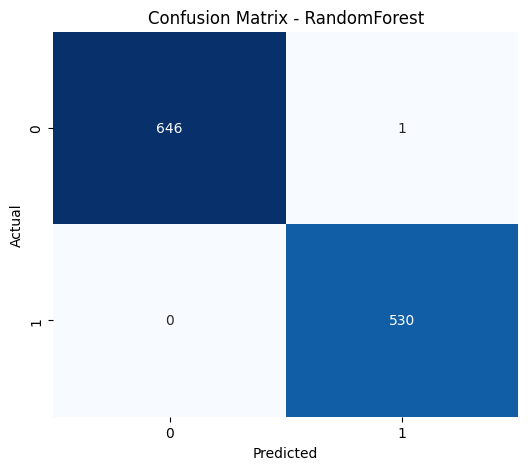


===== LightGBM =====
Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score     support
0              0.998457  1.000000  0.999228   647.00000
1              1.000000  0.998113  0.999056   530.00000
accuracy       0.999150  0.999150  0.999150     0.99915
macro avg      0.999228  0.999057  0.999142  1177.00000
weighted avg   0.999152  0.999150  0.999150  1177.00000


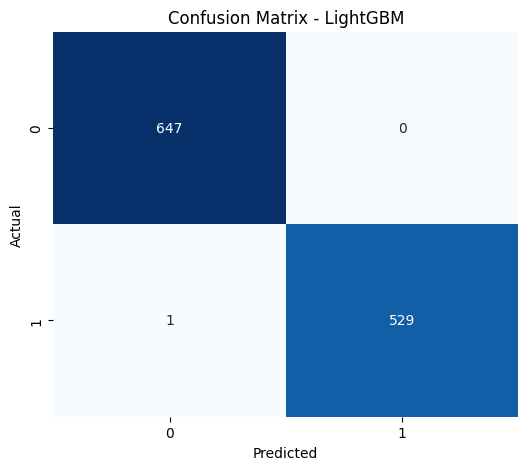


===== XGBoost =====
Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.998454  0.999227   647.00000
1              0.998117  1.000000  0.999057   530.00000
accuracy       0.999150  0.999150  0.999150     0.99915
macro avg      0.999058  0.999227  0.999142  1177.00000
weighted avg   0.999152  0.999150  0.999150  1177.00000


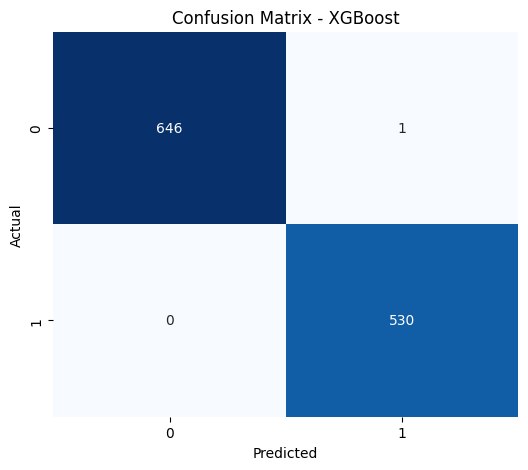


===== CatBoost =====
Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.998454  0.999227   647.00000
1              0.998117  1.000000  0.999057   530.00000
accuracy       0.999150  0.999150  0.999150     0.99915
macro avg      0.999058  0.999227  0.999142  1177.00000
weighted avg   0.999152  0.999150  0.999150  1177.00000


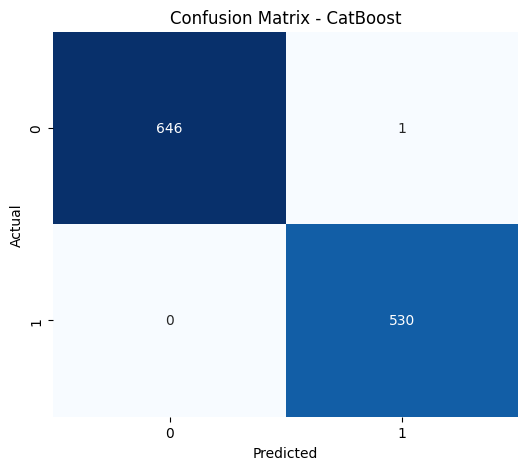

In [12]:
for model_name, result in BC_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

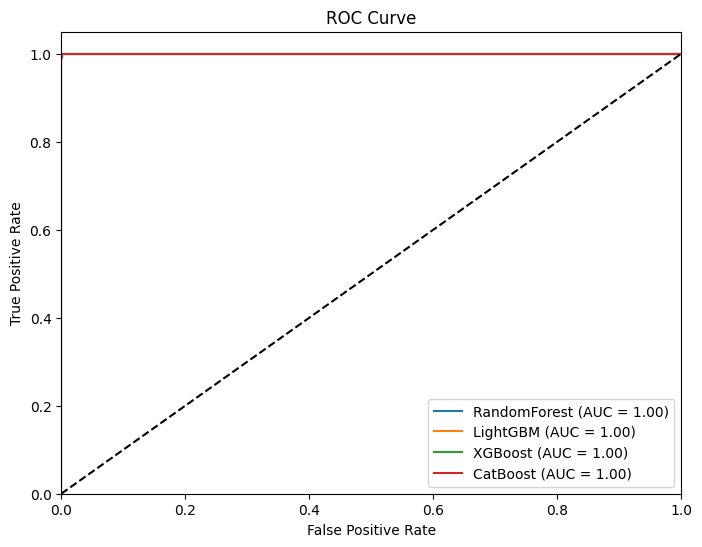

In [13]:
plot_roc_curve(models, X_val_isdynamic, y2_val)

#### 2) 알고리즘2 : CatBoost
- 다들 똑같이 잘나와버려서 hyperparameter tuning 후 성능을 고려해 일반적으로 가장 잘 나오는 CatBoost를 쓸 에정

#### HyperOpt Objective Function

In [14]:
def objective(params):
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y2_train)

    y_pred = model.predict(X_val_isdynamic)
    report = classification_report(y2_val, y_pred, output_dict=True)
    
    f1_score = report['weighted avg']['f1-score']

    return {'loss': -f1_score, 'status': STATUS_OK}


#### HyperOpt Search Space

In [15]:
binary_space = {
    'iterations': hp.randint('iterations', 100, 2000),  # 100~2000
    'depth': hp.randint('depth', 3, 10),  # 3~9
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # 0.01~0.3
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),  # 1~10
    'border_count': hp.randint('border_count', 5, 255),  # 5~254
    'thread_count': -1
}

In [16]:
trials = Trials()
binary_best_params = fmin(fn=objective, space=binary_space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best Hyperparameters:", binary_best_params)

100%|██████████| 50/50 [16:59<00:00, 20.40s/trial, best loss: -0.529848746191832] 
Best Hyperparameters: {'border_count': 235, 'depth': 8, 'iterations': 363, 'l2_leaf_reg': 6.826188311252638, 'learning_rate': 0.15996424127528483}


In [189]:
'''binary_best_params = {
    'border_count': 11,
    'depth': 3,
    'iterations': 1771,
    'l2_leaf_reg': 2.251379478824442,
    'learning_rate': 0.041546553207725316,
    'thread_count': -1, 
    'verbose': 0  
}
binary_model = CatBoostClassifier(**binary_best_params)'''
binary_model = CatBoostClassifier(
    iterations=binary_best_params['iterations'],
    depth=binary_best_params['depth'],
    learning_rate=round(binary_best_params['learning_rate'], 5),
    l2_leaf_reg=round(binary_best_params['l2_leaf_reg'], 5),
    border_count=binary_best_params['border_count'],
    thread_count=binary_best_params['thread_count']
    
    )

In [190]:
best_binary_results = {}
binary_model.fit(X_train_isdynamic, y2_train)
best_binary_y2_pred = binary_model.predict(X_val_isdynamic)

best_binary_acc = accuracy_score(y2_val, best_binary_y2_pred)
best_binary_cm = confusion_matrix(y2_val, best_binary_y2_pred)
best_binary_clf_report = classification_report(y2_val, best_binary_y2_pred, output_dict=True)

print(f"{name} Accuracy: {score:.4f}")

best_binary_results[name] = {
    'accuracy': best_binary_acc,
    'confusion_matrix': best_binary_cm,
    'classification_report': best_binary_clf_report
}

0:	learn: 0.5899714	total: 11.5ms	remaining: 20.4s
1:	learn: 0.4928729	total: 15.4ms	remaining: 13.6s
2:	learn: 0.4060114	total: 19ms	remaining: 11.2s
3:	learn: 0.3387112	total: 22.3ms	remaining: 9.85s
4:	learn: 0.2888389	total: 25.5ms	remaining: 9s
5:	learn: 0.2438107	total: 28.7ms	remaining: 8.45s
6:	learn: 0.2097477	total: 32.6ms	remaining: 8.21s
7:	learn: 0.1721184	total: 36.4ms	remaining: 8.03s
8:	learn: 0.1410355	total: 40.1ms	remaining: 7.86s
9:	learn: 0.1166769	total: 43.7ms	remaining: 7.7s
10:	learn: 0.0976349	total: 47.2ms	remaining: 7.55s
11:	learn: 0.0791783	total: 51.2ms	remaining: 7.51s
12:	learn: 0.0653275	total: 55.1ms	remaining: 7.46s
13:	learn: 0.0545918	total: 59.2ms	remaining: 7.43s
14:	learn: 0.0461874	total: 63.3ms	remaining: 7.41s
15:	learn: 0.0402401	total: 67.4ms	remaining: 7.39s
16:	learn: 0.0339315	total: 71.1ms	remaining: 7.33s
17:	learn: 0.0292549	total: 74.8ms	remaining: 7.28s
18:	learn: 0.0252906	total: 78.1ms	remaining: 7.2s
19:	learn: 0.0224192	total: 8


===== CatBoost =====
Accuracy: 1.0000

Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    647.0
1                   1.0     1.0       1.0    530.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1177.0
weighted avg        1.0     1.0       1.0   1177.0


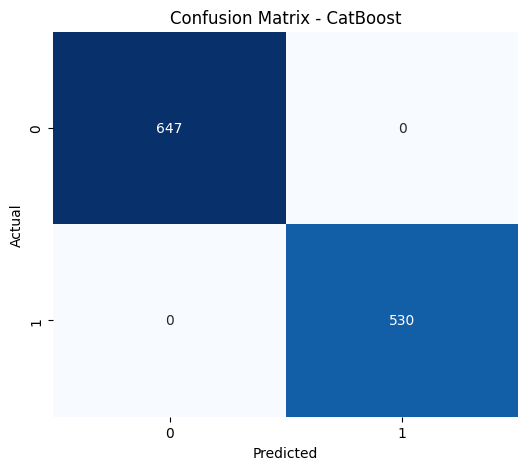

In [191]:
for model_name, result in best_binary_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

## Neural Network
Deep Learning의 힘을 빌려 학습시켜도 성능이 잘 나올 것 같기에 단순한 MLP를 학습시켜 시도해볼까 한다.

In [20]:
X_train_tensor = torch.tensor(X_train_isdynamic, dtype=torch.float32)
y_train_tensor = torch.tensor(y2_train.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_val_isdynamic, dtype=torch.float32)
y_valid_tensor = torch.tensor(y2_val.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [21]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [22]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

num_epochs = 20
criterion = nn.BCELoss()
NN_model = SimpleNN(input_dim=X_train_isdynamic.shape[1]).to(device)
optimizer = optim.Adam(NN_model.parameters(), lr=0.001)

In [23]:
for epoch in range(num_epochs):
    NN_model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            optimizer.zero_grad() 
            outputs = NN_model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item()) 
            pbar.update(1) 

    NN_model.eval()
    with torch.no_grad():
        valid_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = NN_model(batch_X).squeeze()
            valid_loss += criterion(outputs, batch_y).item()
            predicted = (outputs > 0.5).float() 
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {valid_loss/len(valid_loader):.4f}, Validation Accuracy: {accuracy:.4f}')

Epoch 1/20: 100%|██████████| 147/147 [00:01<00:00, 88.14batch/s, loss=0.000211] 


Epoch [1/20], Validation Loss: 0.0032, Validation Accuracy: 0.9992


Epoch 2/20: 100%|██████████| 147/147 [00:01<00:00, 113.19batch/s, loss=0.000146]


Epoch [2/20], Validation Loss: 0.0003, Validation Accuracy: 1.0000


Epoch 3/20: 100%|██████████| 147/147 [00:00<00:00, 154.78batch/s, loss=0.000191]


Epoch [3/20], Validation Loss: 0.0002, Validation Accuracy: 1.0000


Epoch 4/20: 100%|██████████| 147/147 [00:01<00:00, 124.80batch/s, loss=7.98e-6] 


Epoch [4/20], Validation Loss: 0.0002, Validation Accuracy: 1.0000


Epoch 5/20: 100%|██████████| 147/147 [00:00<00:00, 155.90batch/s, loss=3.06e-6] 


Epoch [5/20], Validation Loss: 0.0002, Validation Accuracy: 1.0000


Epoch 6/20: 100%|██████████| 147/147 [00:01<00:00, 142.85batch/s, loss=1.49e-5] 


Epoch [6/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 7/20: 100%|██████████| 147/147 [00:01<00:00, 132.42batch/s, loss=8.01e-7] 


Epoch [7/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 8/20: 100%|██████████| 147/147 [00:01<00:00, 136.37batch/s, loss=7.51e-6]


Epoch [8/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 9/20: 100%|██████████| 147/147 [00:00<00:00, 158.21batch/s, loss=7.98e-6]


Epoch [9/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 10/20: 100%|██████████| 147/147 [00:01<00:00, 139.09batch/s, loss=1.41e-5] 


Epoch [10/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 11/20: 100%|██████████| 147/147 [00:00<00:00, 165.07batch/s, loss=2.75e-6]


Epoch [11/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 12/20: 100%|██████████| 147/147 [00:01<00:00, 128.48batch/s, loss=5.06e-6]


Epoch [12/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 13/20: 100%|██████████| 147/147 [00:00<00:00, 158.95batch/s, loss=2.62e-6]


Epoch [13/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 14/20: 100%|██████████| 147/147 [00:01<00:00, 139.51batch/s, loss=1.68e-7]


Epoch [14/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 15/20: 100%|██████████| 147/147 [00:00<00:00, 157.11batch/s, loss=1.14e-6]


Epoch [15/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 16/20: 100%|██████████| 147/147 [00:01<00:00, 133.75batch/s, loss=2.14e-7]


Epoch [16/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 17/20: 100%|██████████| 147/147 [00:00<00:00, 150.08batch/s, loss=7.32e-7]


Epoch [17/20], Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 18/20: 100%|██████████| 147/147 [00:01<00:00, 142.15batch/s, loss=6.54e-7]


Epoch [18/20], Validation Loss: 0.0000, Validation Accuracy: 1.0000


Epoch 19/20: 100%|██████████| 147/147 [00:00<00:00, 158.31batch/s, loss=2.44e-7]


Epoch [19/20], Validation Loss: 0.0000, Validation Accuracy: 1.0000


Epoch 20/20: 100%|██████████| 147/147 [00:01<00:00, 141.87batch/s, loss=1.7e-6] 


Epoch [20/20], Validation Loss: 0.0000, Validation Accuracy: 1.0000


### 두번째 epoch에서 이미 1.0을 달성했다..
#### overfitting일 수도 있기에 미리 test해볼까 한다.

In [24]:
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')
test = pd.read_csv(test_path)
test = test.drop('subject', axis=1)
is_dynamic = test['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)
test['Activity_dynamic'] = is_dynamic
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,1
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0


In [192]:
X_test_NNbinary = data.drop(['Activity', 'Activity_dynamic'], axis=1)
y_test_NNbinary = data['Activity_dynamic']
X_test_NNbinary = scaler.transform(X_test_NNbinary)

In [193]:
X_test_tensor = torch.tensor(X_test_NNbinary, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_NNbinary, dtype=torch.float32).to(device)
NN_model.eval()

SimpleNN(
  (fc1): Linear(in_features=561, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [194]:
with torch.no_grad():
    outputs = NN_model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    correct = (predicted == y_test_tensor).sum().item()  
    total = y_test_tensor.size(0)
    
accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 1.0000


## 간단한 MLP인 NN_model이 overfitting이 아니라 hyperparamter를 조정할 필요도 없는 아주 훌륭한 모델이었던 사실을 알아냈다!!
### ***최종 pipeline과 같은 방식 대신, ```MLP```를 잘 짜서 ```End-to-End Network```를 만드는 방법이 낫지 않을까..?***
이러한 Insight는 이미 알았으니 추후에 알아보도록 하자.

### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [220]:
models_multi_static = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(objective='multiclass', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, loss_function='MultiClass', random_state=42)
    # 'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
}

In [221]:
static = data[data['Activity_dynamic'] == 0]
static.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,4,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,3,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,4,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,4,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,4,0


In [222]:
X_static = static.drop(['Activity', 'Activity_dynamic'], axis=1)
X_static = scaler.transform(X_static)
y_static = static['Activity']

In [223]:
X_train_static, X_val_static, y_train_static, y_val_static = train_test_split(X_static, y_static, test_size=0.2, random_state=42, stratify=y_static)

In [224]:
print("y_train_static unique classes:", np.unique(y_train_static))
print("y_val_static unique classes:", np.unique(y_val_static))

y_train_static unique classes: [3 4 5]
y_val_static unique classes: [3 4 5]


In [225]:
best_model = None
best_score = 0
STATIC_results = {}

# class_labels = np.array([3, 4, 5])

for name, model in models_multi_static.items():
    '''if name == 'XGBoost':
        model.classes_ = class_labels'''

    model.fit(X_train_static, y_train_static)
    y_pred_static = model.predict(X_val_static)

    acc = accuracy_score(y_val_static, y_pred_static)
    cm = confusion_matrix(y_val_static, y_pred_static)
    clf_report = classification_report(y_val_static, y_pred_static, output_dict=True)

    score = classification_report(y_val_static, y_pred_static, output_dict=True)['accuracy']
    print(f"{name} Accuracy: {score:.4f}")
    
    STATIC_results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    }

    if score >= best_score:
        best_score = score
        best_model = model

print(f"STATIC Best Model: {best_model.__class__.__name__} with Accuracy: {best_score:.4f}")

RandomForest Accuracy: 0.9737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139355
[LightGBM] [Info] Number of data points in the train set: 2587, number of used features: 561
[LightGBM] [Info] Start training from score -1.064788
[LightGBM] [Info] Start training from score -1.090911
[LightGBM] [Info] Start training from score -1.141659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai


===== RandomForest =====
Accuracy: 0.9737

Classification Report:
              precision    recall  f1-score     support
3              1.000000  1.000000  1.000000  223.000000
4              0.958904  0.963303  0.961098  218.000000
5              0.960976  0.956311  0.958637  206.000000
accuracy       0.973725  0.973725  0.973725    0.973725
macro avg      0.973293  0.973204  0.973245  647.000000
weighted avg   0.973728  0.973725  0.973723  647.000000


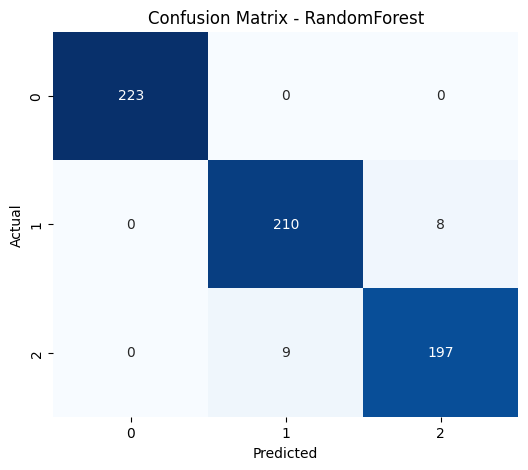


===== LightGBM =====
Accuracy: 0.9861

Classification Report:
              precision    recall  f1-score    support
3              1.000000  1.000000  1.000000  223.00000
4              0.986047  0.972477  0.979215  218.00000
5              0.971292  0.985437  0.978313  206.00000
accuracy       0.986090  0.986090  0.986090    0.98609
macro avg      0.985779  0.985971  0.985843  647.00000
weighted avg   0.986158  0.986090  0.986092  647.00000


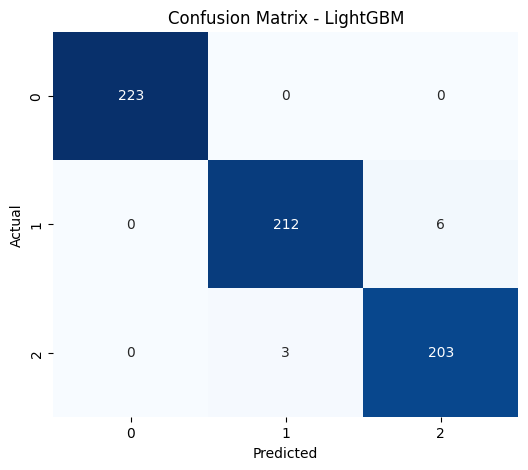


===== CatBoost =====
Accuracy: 0.9861

Classification Report:
              precision    recall  f1-score    support
3              1.000000  1.000000  1.000000  223.00000
4              0.972851  0.986239  0.979499  218.00000
5              0.985222  0.970874  0.977995  206.00000
accuracy       0.986090  0.986090  0.986090    0.98609
macro avg      0.986024  0.985704  0.985831  647.00000
weighted avg   0.986147  0.986090  0.986086  647.00000


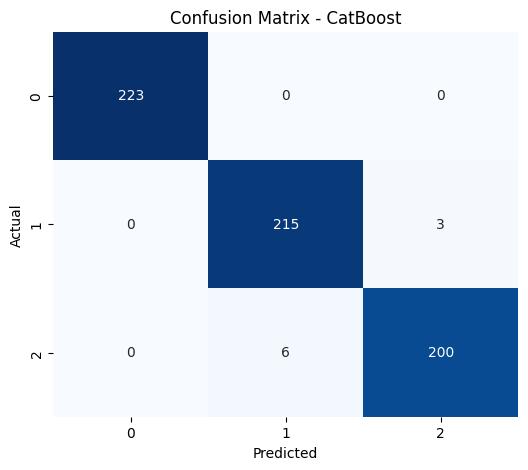

In [226]:
for model_name, result in STATIC_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

## CatBoost 선택!
- HyperOpt로 Hyperparameter Tuning

Objective function

In [233]:
def objective(params):
    model = CatBoostClassifier(
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        bagging_temperature=params['bagging_temperature'],
        border_count=int(params['border_count']),
        random_strength=params['random_strength'],
        grow_policy=params['grow_policy'],
        random_seed=params['random_seed'],
        verbose=0

    )
    model.fit(X_train_static, y_train_static)

    y_pred = model.predict(X_val_static)
    report = classification_report(y_val_static, y_pred, output_dict=True)
    
    f1_score = report['weighted avg']['f1-score']

    return {'loss': -f1_score, 'status': STATUS_OK}


Hyperparameter space

In [234]:
static_space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50), 
    'depth': hp.quniform('depth', 4, 10, 1),  
    'learning_rate': hp.loguniform('learning_rate', -5, -1), 
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),  
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
    'border_count': hp.quniform('border_count', 32, 255, 1),  
    'random_strength': hp.uniform('random_strength', 1e-9, 10),  
    'grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),  
    'random_seed': 42,  
    'verbose': 0
}

Hyperparameter tuning

In [235]:
trials = Trials()
static_best = fmin(fn=objective, space=static_space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best Hyperparameters:", static_best)

100%|██████████| 100/100 [1:01:55<00:00, 37.16s/trial, best loss: -0.990738210249893]
Best Hyperparameters: {'bagging_temperature': 0.7274404944694582, 'border_count': 132.0, 'depth': 4.0, 'grow_policy': 2, 'iterations': 400.0, 'l2_leaf_reg': 2.225632342326058, 'learning_rate': 0.3591002605194688, 'random_strength': 2.0900310904667694}


In [236]:
static_model = CatBoostClassifier(
        iterations=int(static_best['iterations']),
        depth=int(static_best['depth']),
        learning_rate=static_best['learning_rate'],
        l2_leaf_reg=static_best['l2_leaf_reg'],
        bagging_temperature=static_best['bagging_temperature'],
        border_count=int(static_best['border_count']),
        random_strength=static_best['random_strength'],
        grow_policy=['SymmetricTree', 'Depthwise', 'Lossguide'][static_best['grow_policy']], 
        random_seed=42,  
        verbose=0
    )

In [238]:
best_static_results = {}
static_model.fit(X_train_static, y_train_static)
static_y_pred = static_model.predict(X_val_static)

best_static_acc = accuracy_score(y_val_static, static_y_pred)
best_static_cm = confusion_matrix(y_val_static, static_y_pred)
best_static_clf_report = classification_report(y_val_static, static_y_pred, output_dict=True)

print(f"STATIC CatBoost Accuracy: {best_static_acc:.4f}")

best_static_results['STATIC_CatBoost'] = {
    'accuracy': best_static_acc,
    'confusion_matrix': best_static_cm,
    'classification_report': best_static_clf_report
}

STATIC CatBoost Accuracy: 0.9907



===== STATIC_CatBoost =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score     support
3              1.000000  0.995516  0.997753  223.000000
4              0.990783  0.986239  0.988506  218.000000
5              0.980769  0.990291  0.985507  206.000000
accuracy       0.990726  0.990726  0.990726    0.990726
macro avg      0.990518  0.990682  0.990589  647.000000
weighted avg   0.990772  0.990726  0.990738  647.000000


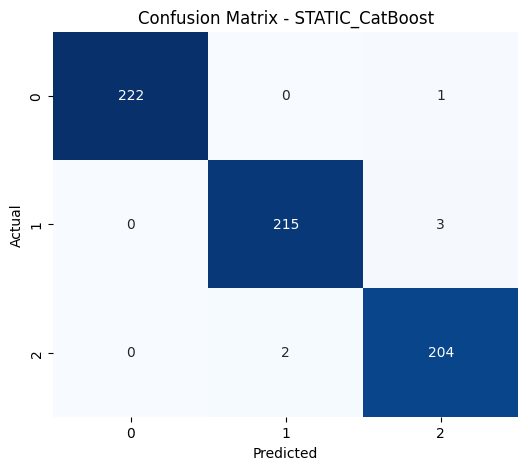

In [239]:
for model_name, result in best_static_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    plot_confusion_matrix(result['confusion_matrix'], model_name)

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [240]:
models_multi = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(objective='multiclass', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, loss_function='MultiClass', random_state=42)
}

In [241]:
dynamic = data[data['Activity_dynamic'] == 1]
dynamic.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,2,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,1,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,0,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,0,1


In [242]:
X_dynamic = dynamic.drop(['Activity', 'Activity_dynamic'], axis=1)
X_dynamic = scaler.transform(X_dynamic)
y_dynamic = dynamic['Activity']

In [243]:
X_train_dynamic, X_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42, stratify=y_dynamic)

In [244]:
best_model = None
best_score = 0
DYNAMIC_results = {}


for name, model in models_multi.items():
    model.fit(X_train_dynamic, y_train_dynamic)
    y_pred_dynamic = model.predict(X_val_dynamic)

    acc = accuracy_score(y_val_dynamic, y_pred_dynamic)
    cm = confusion_matrix(y_val_dynamic, y_pred_dynamic)
    clf_report = classification_report(y_val_dynamic, y_pred_dynamic, output_dict=True)

    score = classification_report(y_val_dynamic, y_pred_dynamic, output_dict=True)['accuracy']
    print(f"{name} Accuracy: {score:.4f}")
    
    DYNAMIC_results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    }

    if score >= best_score:
        best_score = score
        best_model = model

print(f"DYNAMIC Best Model: {best_model.__class__.__name__} with Accuracy: {best_score:.4f}")

RandomForest Accuracy: 0.9868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139791
[LightGBM] [Info] Number of data points in the train set: 2117, number of used features: 561
[LightGBM] [Info] Start training from score -0.975647
[LightGBM] [Info] Start training from score -1.126878
[LightGBM] [Info] Start training from score -1.207285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai


===== RandomForest =====
Accuracy: 0.9868

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.990000  0.994975  200.000000
1              0.977143  0.994186  0.985591  172.000000
2              0.980892  0.974684  0.977778  158.000000
accuracy       0.986792  0.986792  0.986792    0.986792
macro avg      0.986012  0.986290  0.986114  530.000000
weighted avg   0.986886  0.986792  0.986803  530.000000


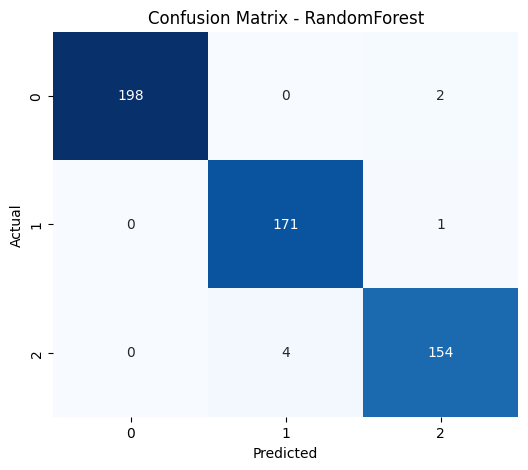


===== LightGBM =====
Accuracy: 0.9981

Classification Report:
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000  200.000000
1              1.000000  0.994186  0.997085  172.000000
2              0.993711  1.000000  0.996845  158.000000
accuracy       0.998113  0.998113  0.998113    0.998113
macro avg      0.997904  0.998062  0.997977  530.000000
weighted avg   0.998125  0.998113  0.998113  530.000000


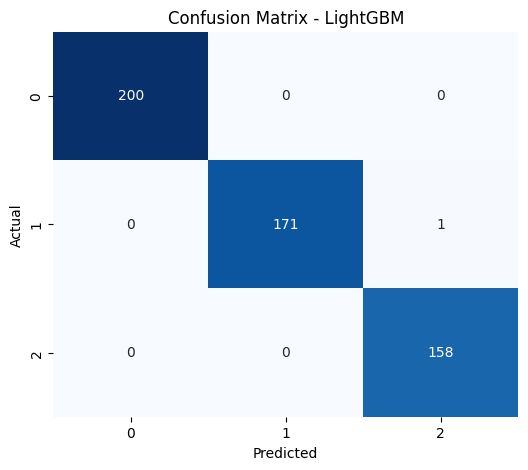


===== XGBoost =====
Accuracy: 0.9962

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.995000  0.997494  200.000000
1              0.994186  0.994186  0.994186  172.000000
2              0.993711  1.000000  0.996845  158.000000
accuracy       0.996226  0.996226  0.996226    0.996226
macro avg      0.995966  0.996395  0.996175  530.000000
weighted avg   0.996238  0.996226  0.996227  530.000000


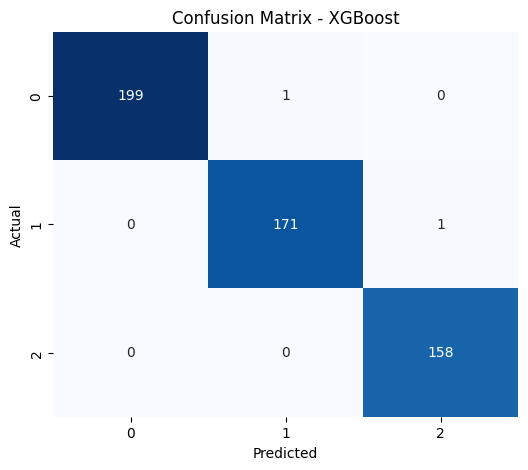


===== CatBoost =====
Accuracy: 0.9962

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.990000  0.994975  200.000000
1              0.994220  1.000000  0.997101  172.000000
2              0.993711  1.000000  0.996845  158.000000
accuracy       0.996226  0.996226  0.996226    0.996226
macro avg      0.995977  0.996667  0.996307  530.000000
weighted avg   0.996249  0.996226  0.996223  530.000000


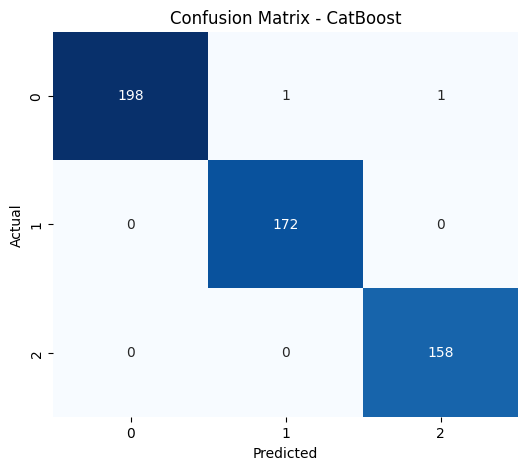

In [245]:
for model_name, result in DYNAMIC_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

## LightGBM 선택!
- HyperOpt로 Hyperparameter Tuning

Objective function

In [247]:
def objective(params):
    model = LGBMClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_samples=int(params['min_child_samples']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        bagging_fraction=params['bagging_fraction'],
        random_state=42
    )
    
    model.fit(X_train_dynamic, y_train_dynamic)
    y_pred = model.predict(X_val_dynamic)

    report = classification_report(y_val_dynamic, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    
    return {'loss': -f1_score, 'status': STATUS_OK}

In [248]:
dynamic_space = {
    'learning_rate': hp.loguniform('learning_rate', -5, -1), 
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9, 12, 15]),
    'num_leaves': hp.choice('num_leaves', [20, 31, 50, 70, 100]),
    'min_child_samples': hp.choice('min_child_samples', [10, 20, 30, 40, 50]),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'random_state': 42 
}

In [249]:
trials = Trials()
dynamic_best = fmin(fn=objective, space=dynamic_space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best Hyperparameters:", dynamic_best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Warning] bagging_fraction is set=0.8013647431013229, subsample=0.7829859312420762 will be ignored. Current value: bagging_fraction=0.8013647431013229
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.8013647431013229, subsample=0.7829859312420762 will be ignored. Current value: bagging_fraction=0.8013647431013229
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139791                   
[LightGBM] [Info] Number of data points in the train set: 2117, number of used features: 561
[LightGBM] [Info] Start training from score -0.975647 
[LightGBM] [Info] Start training from score -1.1268

In [52]:
'''dynamic_best_params = {
    'colsample_bytree': 0.748031670722321,
    'learning_rate': 0.2624239125286934,
    'max_depth': 9,
    'min_child_samples': 40,
    'num_leaves': 31,
    'subsample': 0.9482085061062364
}
dynamic_model = LGBMClassifier(**dynamic_best_params)'''

"dynamic_best_params = {\n    'colsample_bytree': 0.748031670722321,\n    'learning_rate': 0.2624239125286934,\n    'max_depth': 9,\n    'min_child_samples': 40,\n    'num_leaves': 31,\n    'subsample': 0.9482085061062364\n}\ndynamic_model = LGBMClassifier(**dynamic_best_params)"

In [257]:
dynamic_model = LGBMClassifier(
        iteration=300,
        learning_rate=round(dynamic_best['learning_rate'], 5),
        max_depth=int(dynamic_best['max_depth']),
        num_leaves=int(dynamic_best['num_leaves']),
        min_child_samples=int(dynamic_best['min_child_samples']),
        subsample=round(dynamic_best['subsample'], 5),
        colsample_bytree=dynamic_best['colsample_bytree'],
        bagging_fraction=round(dynamic_best['bagging_fraction'], 5),
        random_state=42
    )

In [258]:
best_dynamic_results = {}
dynamic_model.fit(X_train_dynamic, y_train_dynamic)
dynamic_y_pred = dynamic_model.predict(X_val_dynamic)

best_dynamic_acc = accuracy_score(y_val_dynamic, dynamic_y_pred)
best_dynamic_cm = confusion_matrix(y_val_dynamic, dynamic_y_pred)
best_dynamic_clf_report = classification_report(y_val_dynamic, dynamic_y_pred, output_dict=True)

print(f"DYNAMIC LightGBM Accuracy: {best_dynamic_acc:.4f}")

best_dynamic_results['DYNAMIC_LightGBM'] = {
    'accuracy': best_dynamic_acc,
    'confusion_matrix': best_dynamic_cm,
    'classification_report': best_dynamic_clf_report
}

[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] bagging_fraction is set=0.50517, subsample=0.85678 will be ignored. Current value: bagging_fraction=0.50517
[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] bagging_fraction is set=0.50517, subsample=0.85678 will be ignored. Current value: bagging_fraction=0.50517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139791
[LightGBM] [Info] Number of data points in the train set: 2117, number of used features: 561
[LightGBM] [Info] Start training from score -0.975647
[LightGBM] [Info] Start training from score -1.126878
[LightGBM] [Info] Start training from score -1.207285
[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] bagging_fraction is set=0.50517, subsample=0.85678 will be ignored. Current value: bagging_fraction=0.50517
DYNAMIC Li


===== DYNAMIC_LightGBM =====
Accuracy: 0.9981

Classification Report:
              precision    recall  f1-score     support
0              0.995025  1.000000  0.997506  200.000000
1              1.000000  0.994186  0.997085  172.000000
2              1.000000  1.000000  1.000000  158.000000
accuracy       0.998113  0.998113  0.998113    0.998113
macro avg      0.998342  0.998062  0.998197  530.000000
weighted avg   0.998123  0.998113  0.998113  530.000000


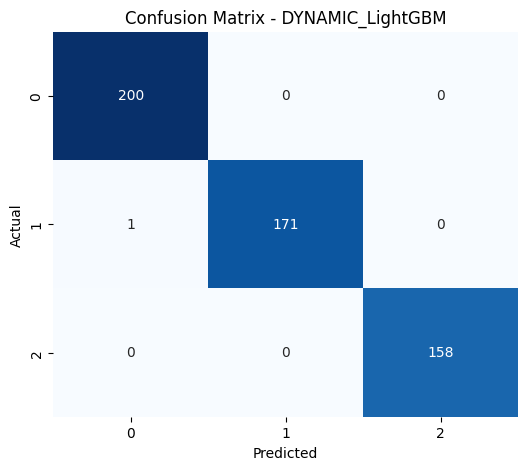

In [259]:
for model_name, result in best_dynamic_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    plot_confusion_matrix(result['confusion_matrix'], model_name)

### (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

### Test data 불러와 preprocessing 하는 함수

In [260]:
def load_and_preprocess_data(file_path):
    test = pd.read_csv(file_path)
    test = test.drop('subject', axis=1)

    # 'Activity_dynamic' 칼럼 생성
    test['Activity_dynamic'] = test['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

    # 'Activity' 칼럼 변환
    test['Activity'] = test['Activity'].map({
        'WALKING': 0,
        'WALKING_UPSTAIRS': 1,
        'WALKING_DOWNSTAIRS': 2,
        'LAYING': 3,
        'STANDING': 4,
        'SITTING': 5
    })

    X_test = test.drop(['Activity', 'Activity_dynamic'], axis=1)
    X_test = scaler.transform(X_test)

    y_test = test['Activity']
    y_test_binary = test['Activity_dynamic']

    y_test_static = test[test['Activity_dynamic'] == 0]['Activity']
    y_test_dynamic = test[test['Activity_dynamic'] == 1]['Activity']
    
    return X_test, y_test, y_test_binary, y_test_static, y_test_dynamic, test.index

### Model을 Evaluation하는 함수

In [261]:
def evaluate_model(model, X, y_true, model_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred)
    
    print(f"\n{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(clf_report)
    
    return y_pred, accuracy, cm, clf_report

### 최종 Pipeline

In [265]:
def run_pipeline(test_file_path, binary_model, static_model, dynamic_model):
    # 데이터 로드 및 전처리
    X_test, y_test, y_test_binary, y_test_static, y_test_dynamic, indices = load_and_preprocess_data(test_file_path)
    
    # 이진 분류 성능 평가
    binary_y_pred, binary_acc, binary_cm, binary_clf_report = evaluate_model(binary_model, X_test, y_test_binary, "Binary Classification")

    # Static 및 Dynamic 데이터 분리
    static_indices = indices[binary_y_pred == 0]
    dynamic_indices = indices[binary_y_pred == 1]
    
    X_test_static = X_test[static_indices]
    X_test_dynamic = X_test[dynamic_indices]

    # Static 데이터 분류 및 평가
    static_y_pred, static_acc, static_cm, static_clf_report = evaluate_model(static_model, X_test_static, y_test_static, "Static Activity Classification")

    # Dynamic 데이터 분류 및 평가
    dynamic_y_pred, dynamic_acc, dynamic_cm, dynamic_clf_report = evaluate_model(dynamic_model, X_test_dynamic, y_test_dynamic, "Dynamic Activity Classification")

    # 최종 예측값을 원래 순서에 맞게 병합
    final_y_pred = np.zeros_like(y_test)
    final_y_pred[static_indices] = static_y_pred.flatten()
    final_y_pred[dynamic_indices] = dynamic_y_pred.flatten()

    # 전체 분류 성능 평가 (6가지 클래스 예측 vs y_test)
    overall_acc = accuracy_score(y_test, final_y_pred)
    overall_cm = confusion_matrix(y_test, final_y_pred)
    overall_clf_report = classification_report(y_test, final_y_pred)
    
    print("\nOverall Classification (6 classes) Evaluation:")
    print(f"Accuracy: {overall_acc:.4f}")
    print("Confusion Matrix:")
    print(overall_cm)
    print("Classification Report:")
    print(overall_clf_report)

    # 결과 반환
    results = {
        'Binary Classification': {
            'accuracy': binary_acc,
            'confusion_matrix': binary_cm,
            'classification_report': binary_clf_report
        },
        'Static Activity Classification': {
            'accuracy': static_acc,
            'confusion_matrix': static_cm,
            'classification_report': static_clf_report
        },
        'Dynamic Activity Classification': {
            'accuracy': dynamic_acc,
            'confusion_matrix': dynamic_cm,
            'classification_report': dynamic_clf_report
        },
        'Overall Classification': {
            'accuracy': overall_acc,
            'confusion_matrix': overall_cm,
            'classification_report': overall_clf_report
        }
    }
    
    return results


### Pipeline 호출

In [266]:
test_file_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

# 이미 위에서 load된 모델들
# binary_model = CatBoostClassifier(**binary_best_params)  # 이진 분류 모델
# static_model = LGBMClassifier(**static_best_params)      # 정적 활동 분류 모델
# dynamic_model = LGBMClassifier(**dynamic_best_params)     # 동적 활동 분류 모델

FINAL_RESULT = run_pipeline(test_file_path, binary_model, static_model, dynamic_model)


Binary Classification Model Evaluation:
Accuracy: 1.0000
Confusion Matrix:
[[833   0]
 [  0 638]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471


Static Activity Classification Model Evaluation:
Accuracy: 0.9796
Confusion Matrix:
[[289   0   3]
 [  0 281   6]
 [  0   8 246]]
Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.99      0.99       292
           4       0.97      0.98      0.98       287
           5       0.96      0.97      0.97       254

    accuracy                           0.98       833
   macro avg       0.98      0.98      0.98       833
weighted avg       0.98      0.98      0.98       833

[LightGBM] [Warn

## End-to-End Network

### Training

In [277]:
class DataLoaderPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.scaler = StandardScaler()

    def load_and_preprocess_data(self):
        NN_data = pd.read_csv(self.file_path)
        NN_data = NN_data.drop('subject', axis=1)
        
        NN_data['Activity'] = NN_data['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_NN = NN_data.drop('Activity', axis=1).to_numpy()
        y_NN = NN_data['Activity']

        #X_NN = self.scaler.fit_transform(X_NN)

        X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(
            X_NN, y_NN, test_size=0.2, random_state=42, stratify=y_NN)

        return X_train_NN, X_val_NN, y_train_NN, y_val_NN

    def convert_to_tensor(self, X_train_NN, y_train_NN, X_val_NN, y_val_NN):
        X_train_NN_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
        y_train_NN_tensor = torch.tensor(y_train_NN.values, dtype=torch.float32)
        X_val_NN_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
        y_val_NN_tensor = torch.tensor(y_val_NN.values, dtype=torch.float32)

        train_NN_dataset = TensorDataset(X_train_NN_tensor, y_train_NN_tensor)
        valid_NN_dataset = TensorDataset(X_val_NN_tensor, y_val_NN_tensor)
        train_NN_loader = DataLoader(train_NN_dataset, batch_size=32, shuffle=True)
        valid_NN_loader = DataLoader(valid_NN_dataset, batch_size=32, shuffle=False)

        return train_NN_loader, valid_NN_loader

In [278]:
'''class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.dropout1 = nn.Dropout(p=0.5)  
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  
        self.dropout2 = nn.Dropout(p=0.5)  
        
        self.fc3 = nn.Linear(64, 32)  
        self.bn3 = nn.BatchNorm1d(32)  
        
        self.fc4 = nn.Linear(32, 6)  

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))  
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))  
        x = F.leaky_relu(self.bn3(self.fc3(x)))  
        x = self.fc4(x)  
        return torch.softmax(x, dim=1)'''
    
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)

        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.fc6 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.leaky_relu(self.bn4(self.fc4(x))))
        x = F.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x) 
        return x

In [279]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes=6):
        super(CNN1D, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * (input_dim // 4), 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Input을 (batch_size, 1, 561)로 변환
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)  # Flattening
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        x = self.fc2(x)
        return x

In [280]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device, scheduler, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.scheduler = scheduler
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        self.best_accuracy = 0  # 최적 성능 기록
        self.save_path = save_path  # 모델 저장 경로

    def train(self, train_NN_loader, valid_NN_loader, num_epochs):
        self.model.to(self.device)

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0
            correct_train = 0
            total_train = 0

            with tqdm(total=len(train_NN_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for batch_X, batch_y in train_NN_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    self.optimizer.zero_grad()

                    # 모델에 입력값을 전달하여 예측값 계산 (softmax 없이 logits 사용)
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)  # CrossEntropyLoss는 logits를 기대

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    
                    # argmax로 예측 클래스 계산
                    predicted = torch.argmax(outputs, dim=1)
                    total_train += batch_y.size(0)
                    correct_train += (predicted == batch_y).sum().item()

                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            epoch_train_loss = running_loss / len(train_NN_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(train_accuracy)

            # 평가 및 best model 저장
            self.evaluate_and_save_best(valid_NN_loader, epoch)

    def evaluate_and_save_best(self, valid_NN_loader, epoch):
        self.model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_X, batch_y in valid_NN_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                # 모델에 입력값을 전달하여 예측값 계산
                outputs = self.model(batch_X)
                valid_loss += self.criterion(outputs, batch_y).item()
                
                # argmax로 예측 클래스 계산
                predicted = torch.argmax(outputs, dim=1)
                total_valid += batch_y.size(0)
                correct_valid += (predicted == batch_y).sum().item()

        epoch_valid_loss = valid_loss / len(valid_NN_loader)
        valid_accuracy = correct_valid / total_valid
        self.valid_losses.append(epoch_valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}], Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

        # 최고 검증 정확도 갱신 시 모델 저장
        if valid_accuracy > self.best_accuracy:
            self.best_accuracy = valid_accuracy
            self.save_model()

    def save_model(self):
        """최고 성능을 기록한 모델을 저장"""
        torch.save(self.model.state_dict(), self.save_path)
        print(f"Best model saved with accuracy: {self.best_accuracy:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


Epoch 1/100: 100%|██████████| 147/147 [00:03<00:00, 47.04batch/s, loss=1.5] 


Epoch [1], Validation Loss: 1.1891, Validation Accuracy: 0.7281
Best model saved with accuracy: 0.7281


Epoch 2/100: 100%|██████████| 147/147 [00:02<00:00, 50.48batch/s, loss=0.945]


Epoch [2], Validation Loss: 0.8853, Validation Accuracy: 0.8326
Best model saved with accuracy: 0.8326


Epoch 3/100: 100%|██████████| 147/147 [00:03<00:00, 47.57batch/s, loss=0.838]


Epoch [3], Validation Loss: 0.6358, Validation Accuracy: 0.8845
Best model saved with accuracy: 0.8845


Epoch 4/100: 100%|██████████| 147/147 [00:03<00:00, 45.88batch/s, loss=0.696]


Epoch [4], Validation Loss: 0.4587, Validation Accuracy: 0.9150
Best model saved with accuracy: 0.9150


Epoch 5/100: 100%|██████████| 147/147 [00:02<00:00, 49.56batch/s, loss=0.469]


Epoch [5], Validation Loss: 0.3318, Validation Accuracy: 0.9380
Best model saved with accuracy: 0.9380


Epoch 6/100: 100%|██████████| 147/147 [00:03<00:00, 47.36batch/s, loss=0.334]


Epoch [6], Validation Loss: 0.2488, Validation Accuracy: 0.9490
Best model saved with accuracy: 0.9490


Epoch 7/100: 100%|██████████| 147/147 [00:03<00:00, 43.24batch/s, loss=0.217]


Epoch [7], Validation Loss: 0.2042, Validation Accuracy: 0.9592
Best model saved with accuracy: 0.9592


Epoch 8/100: 100%|██████████| 147/147 [00:02<00:00, 49.86batch/s, loss=0.37] 


Epoch [8], Validation Loss: 0.1990, Validation Accuracy: 0.9414


Epoch 9/100: 100%|██████████| 147/147 [00:02<00:00, 53.77batch/s, loss=0.21] 


Epoch [9], Validation Loss: 0.1364, Validation Accuracy: 0.9669
Best model saved with accuracy: 0.9669


Epoch 10/100: 100%|██████████| 147/147 [00:02<00:00, 53.07batch/s, loss=0.187]


Epoch [10], Validation Loss: 0.1771, Validation Accuracy: 0.9439


Epoch 11/100: 100%|██████████| 147/147 [00:02<00:00, 52.38batch/s, loss=0.104] 


Epoch [11], Validation Loss: 0.1221, Validation Accuracy: 0.9643


Epoch 12/100: 100%|██████████| 147/147 [00:02<00:00, 52.83batch/s, loss=0.196] 


Epoch [12], Validation Loss: 0.1061, Validation Accuracy: 0.9711
Best model saved with accuracy: 0.9711


Epoch 13/100: 100%|██████████| 147/147 [00:02<00:00, 52.75batch/s, loss=0.124] 


Epoch [13], Validation Loss: 0.2308, Validation Accuracy: 0.9176


Epoch 14/100: 100%|██████████| 147/147 [00:02<00:00, 55.28batch/s, loss=0.413] 


Epoch [14], Validation Loss: 0.0869, Validation Accuracy: 0.9720
Best model saved with accuracy: 0.9720


Epoch 15/100: 100%|██████████| 147/147 [00:02<00:00, 53.53batch/s, loss=0.0698]


Epoch [15], Validation Loss: 0.0992, Validation Accuracy: 0.9694


Epoch 16/100: 100%|██████████| 147/147 [00:02<00:00, 54.76batch/s, loss=0.177] 


Epoch [16], Validation Loss: 0.0898, Validation Accuracy: 0.9694


Epoch 17/100: 100%|██████████| 147/147 [00:02<00:00, 53.18batch/s, loss=0.0838]


Epoch [17], Validation Loss: 0.0727, Validation Accuracy: 0.9779
Best model saved with accuracy: 0.9779


Epoch 18/100: 100%|██████████| 147/147 [00:02<00:00, 51.74batch/s, loss=0.0709]


Epoch [18], Validation Loss: 0.0807, Validation Accuracy: 0.9728


Epoch 19/100: 100%|██████████| 147/147 [00:02<00:00, 53.74batch/s, loss=0.0703]


Epoch [19], Validation Loss: 0.0818, Validation Accuracy: 0.9711


Epoch 20/100: 100%|██████████| 147/147 [00:02<00:00, 53.62batch/s, loss=0.11]  


Epoch [20], Validation Loss: 0.1814, Validation Accuracy: 0.9405


Epoch 21/100: 100%|██████████| 147/147 [00:02<00:00, 53.89batch/s, loss=0.102] 


Epoch [21], Validation Loss: 0.1133, Validation Accuracy: 0.9643


Epoch 22/100: 100%|██████████| 147/147 [00:02<00:00, 54.01batch/s, loss=0.0793]


Epoch [22], Validation Loss: 0.0636, Validation Accuracy: 0.9762


Epoch 23/100: 100%|██████████| 147/147 [00:02<00:00, 54.60batch/s, loss=0.123] 


Epoch [23], Validation Loss: 0.0628, Validation Accuracy: 0.9771


Epoch 24/100: 100%|██████████| 147/147 [00:02<00:00, 55.21batch/s, loss=0.126] 


Epoch [24], Validation Loss: 0.0579, Validation Accuracy: 0.9796
Best model saved with accuracy: 0.9796


Epoch 25/100: 100%|██████████| 147/147 [00:02<00:00, 54.74batch/s, loss=0.0404]


Epoch [25], Validation Loss: 0.0580, Validation Accuracy: 0.9788


Epoch 26/100: 100%|██████████| 147/147 [00:02<00:00, 54.23batch/s, loss=0.0859]


Epoch [26], Validation Loss: 0.0659, Validation Accuracy: 0.9771


Epoch 27/100: 100%|██████████| 147/147 [00:02<00:00, 54.59batch/s, loss=0.0483]


Epoch [27], Validation Loss: 0.1239, Validation Accuracy: 0.9558


Epoch 28/100: 100%|██████████| 147/147 [00:02<00:00, 51.20batch/s, loss=0.127] 


Epoch [28], Validation Loss: 0.0715, Validation Accuracy: 0.9779


Epoch 29/100: 100%|██████████| 147/147 [00:02<00:00, 53.51batch/s, loss=0.0554]


Epoch [29], Validation Loss: 0.3491, Validation Accuracy: 0.8955


Epoch 30/100: 100%|██████████| 147/147 [00:02<00:00, 53.35batch/s, loss=0.0403]


Epoch [30], Validation Loss: 0.0840, Validation Accuracy: 0.9686


Epoch 31/100: 100%|██████████| 147/147 [00:02<00:00, 53.04batch/s, loss=0.201] 


Epoch [31], Validation Loss: 0.0581, Validation Accuracy: 0.9830
Best model saved with accuracy: 0.9830


Epoch 32/100: 100%|██████████| 147/147 [00:02<00:00, 53.20batch/s, loss=0.0192]


Epoch [32], Validation Loss: 0.0670, Validation Accuracy: 0.9788


Epoch 33/100: 100%|██████████| 147/147 [00:02<00:00, 51.99batch/s, loss=0.0588]


Epoch [33], Validation Loss: 0.0741, Validation Accuracy: 0.9754


Epoch 34/100: 100%|██████████| 147/147 [00:02<00:00, 53.26batch/s, loss=0.0207]


Epoch [34], Validation Loss: 0.0659, Validation Accuracy: 0.9754


Epoch 35/100: 100%|██████████| 147/147 [00:02<00:00, 54.51batch/s, loss=0.03]  


Epoch [35], Validation Loss: 0.0514, Validation Accuracy: 0.9830


Epoch 36/100: 100%|██████████| 147/147 [00:02<00:00, 53.34batch/s, loss=0.0293] 


Epoch [36], Validation Loss: 0.1485, Validation Accuracy: 0.9524


Epoch 37/100: 100%|██████████| 147/147 [00:02<00:00, 51.18batch/s, loss=0.0216] 


Epoch [37], Validation Loss: 0.0546, Validation Accuracy: 0.9847
Best model saved with accuracy: 0.9847


Epoch 38/100: 100%|██████████| 147/147 [00:02<00:00, 54.78batch/s, loss=0.152]  


Epoch [38], Validation Loss: 0.0975, Validation Accuracy: 0.9686


Epoch 39/100: 100%|██████████| 147/147 [00:02<00:00, 53.24batch/s, loss=0.015]  


Epoch [39], Validation Loss: 0.0695, Validation Accuracy: 0.9779


Epoch 40/100: 100%|██████████| 147/147 [00:02<00:00, 53.71batch/s, loss=0.0416] 


Epoch [40], Validation Loss: 0.1554, Validation Accuracy: 0.9524


Epoch 41/100: 100%|██████████| 147/147 [00:02<00:00, 50.93batch/s, loss=0.0457] 


Epoch [41], Validation Loss: 0.0545, Validation Accuracy: 0.9822


Epoch 42/100: 100%|██████████| 147/147 [00:02<00:00, 52.29batch/s, loss=0.0767]


Epoch [42], Validation Loss: 0.0511, Validation Accuracy: 0.9839


Epoch 43/100: 100%|██████████| 147/147 [00:02<00:00, 51.00batch/s, loss=0.137]  


Epoch [43], Validation Loss: 0.0634, Validation Accuracy: 0.9788


Epoch 44/100: 100%|██████████| 147/147 [00:02<00:00, 49.17batch/s, loss=0.0463] 


Epoch [44], Validation Loss: 0.1285, Validation Accuracy: 0.9601


Epoch 45/100: 100%|██████████| 147/147 [00:02<00:00, 54.12batch/s, loss=0.0328] 


Epoch [45], Validation Loss: 0.0590, Validation Accuracy: 0.9813


Epoch 46/100: 100%|██████████| 147/147 [00:02<00:00, 53.68batch/s, loss=0.0445] 


Epoch [46], Validation Loss: 0.0711, Validation Accuracy: 0.9771


Epoch 47/100: 100%|██████████| 147/147 [00:02<00:00, 52.59batch/s, loss=0.0172] 


Epoch [47], Validation Loss: 0.0519, Validation Accuracy: 0.9805


Epoch 48/100: 100%|██████████| 147/147 [00:02<00:00, 52.88batch/s, loss=0.0244] 


Epoch [48], Validation Loss: 0.0685, Validation Accuracy: 0.9771


Epoch 49/100: 100%|██████████| 147/147 [00:02<00:00, 53.71batch/s, loss=0.127]  


Epoch [49], Validation Loss: 0.0751, Validation Accuracy: 0.9745


Epoch 50/100: 100%|██████████| 147/147 [00:02<00:00, 52.95batch/s, loss=0.0185] 


Epoch [50], Validation Loss: 0.0710, Validation Accuracy: 0.9762


Epoch 51/100: 100%|██████████| 147/147 [00:02<00:00, 54.86batch/s, loss=0.0291] 


Epoch [51], Validation Loss: 0.0676, Validation Accuracy: 0.9754


Epoch 52/100: 100%|██████████| 147/147 [00:02<00:00, 53.62batch/s, loss=0.0308] 


Epoch [52], Validation Loss: 0.0785, Validation Accuracy: 0.9762


Epoch 53/100: 100%|██████████| 147/147 [00:02<00:00, 52.46batch/s, loss=0.0328] 


Epoch [53], Validation Loss: 0.1436, Validation Accuracy: 0.9592


Epoch 54/100: 100%|██████████| 147/147 [00:02<00:00, 52.70batch/s, loss=0.0142] 


Epoch [54], Validation Loss: 0.0534, Validation Accuracy: 0.9839


Epoch 55/100: 100%|██████████| 147/147 [00:02<00:00, 53.93batch/s, loss=0.154]  


Epoch [55], Validation Loss: 0.0698, Validation Accuracy: 0.9754


Epoch 56/100: 100%|██████████| 147/147 [00:02<00:00, 53.64batch/s, loss=0.0638] 


Epoch [56], Validation Loss: 0.1665, Validation Accuracy: 0.9507


Epoch 57/100: 100%|██████████| 147/147 [00:02<00:00, 54.28batch/s, loss=0.0334] 


Epoch [57], Validation Loss: 0.0612, Validation Accuracy: 0.9805


Epoch 58/100: 100%|██████████| 147/147 [00:02<00:00, 53.03batch/s, loss=0.194]  


Epoch [58], Validation Loss: 0.0913, Validation Accuracy: 0.9728


Epoch 59/100: 100%|██████████| 147/147 [00:02<00:00, 52.28batch/s, loss=0.00799]


Epoch [59], Validation Loss: 0.0671, Validation Accuracy: 0.9805


Epoch 60/100: 100%|██████████| 147/147 [00:02<00:00, 55.24batch/s, loss=0.0123] 


Epoch [60], Validation Loss: 0.0788, Validation Accuracy: 0.9745


Epoch 61/100: 100%|██████████| 147/147 [00:02<00:00, 52.58batch/s, loss=0.00907]


Epoch [61], Validation Loss: 0.0590, Validation Accuracy: 0.9796


Epoch 62/100: 100%|██████████| 147/147 [00:02<00:00, 54.04batch/s, loss=0.303]  


Epoch [62], Validation Loss: 0.1396, Validation Accuracy: 0.9575


Epoch 63/100: 100%|██████████| 147/147 [00:02<00:00, 52.41batch/s, loss=0.0346] 


Epoch [63], Validation Loss: 0.0883, Validation Accuracy: 0.9728


Epoch 64/100: 100%|██████████| 147/147 [00:02<00:00, 52.53batch/s, loss=0.054]  


Epoch [64], Validation Loss: 0.0938, Validation Accuracy: 0.9711


Epoch 65/100: 100%|██████████| 147/147 [00:02<00:00, 52.77batch/s, loss=0.0208] 


Epoch [65], Validation Loss: 0.0533, Validation Accuracy: 0.9839


Epoch 66/100: 100%|██████████| 147/147 [00:02<00:00, 52.84batch/s, loss=0.00726]


Epoch [66], Validation Loss: 0.0394, Validation Accuracy: 0.9890
Best model saved with accuracy: 0.9890


Epoch 67/100: 100%|██████████| 147/147 [00:02<00:00, 52.52batch/s, loss=0.0386] 


Epoch [67], Validation Loss: 0.0599, Validation Accuracy: 0.9822


Epoch 68/100: 100%|██████████| 147/147 [00:02<00:00, 54.63batch/s, loss=0.142]  


Epoch [68], Validation Loss: 0.1192, Validation Accuracy: 0.9652


Epoch 69/100: 100%|██████████| 147/147 [00:02<00:00, 54.35batch/s, loss=0.0916] 


Epoch [69], Validation Loss: 0.0480, Validation Accuracy: 0.9847


Epoch 70/100: 100%|██████████| 147/147 [00:02<00:00, 54.73batch/s, loss=0.0282] 


Epoch [70], Validation Loss: 0.0556, Validation Accuracy: 0.9830


Epoch 71/100: 100%|██████████| 147/147 [00:02<00:00, 52.52batch/s, loss=0.0521] 


Epoch [71], Validation Loss: 0.0829, Validation Accuracy: 0.9754


Epoch 72/100: 100%|██████████| 147/147 [00:02<00:00, 54.46batch/s, loss=0.0104] 


Epoch [72], Validation Loss: 0.0656, Validation Accuracy: 0.9805


Epoch 73/100: 100%|██████████| 147/147 [00:03<00:00, 47.38batch/s, loss=0.0134] 


Epoch [73], Validation Loss: 0.0474, Validation Accuracy: 0.9856


Epoch 74/100: 100%|██████████| 147/147 [00:02<00:00, 52.60batch/s, loss=0.00368]


Epoch [74], Validation Loss: 0.0388, Validation Accuracy: 0.9881


Epoch 75/100: 100%|██████████| 147/147 [00:03<00:00, 47.93batch/s, loss=0.0824] 


Epoch [75], Validation Loss: 0.0540, Validation Accuracy: 0.9822


Epoch 76/100: 100%|██████████| 147/147 [00:02<00:00, 50.29batch/s, loss=0.00653]


Epoch [76], Validation Loss: 0.0488, Validation Accuracy: 0.9847


Epoch 77/100: 100%|██████████| 147/147 [00:02<00:00, 51.47batch/s, loss=0.0267] 


Epoch [77], Validation Loss: 0.0477, Validation Accuracy: 0.9830


Epoch 78/100: 100%|██████████| 147/147 [00:02<00:00, 53.68batch/s, loss=0.00576]


Epoch [78], Validation Loss: 0.0411, Validation Accuracy: 0.9856


Epoch 79/100: 100%|██████████| 147/147 [00:02<00:00, 54.56batch/s, loss=0.00377]


Epoch [79], Validation Loss: 0.0675, Validation Accuracy: 0.9805


Epoch 80/100: 100%|██████████| 147/147 [00:02<00:00, 50.78batch/s, loss=0.0182] 


Epoch [80], Validation Loss: 0.1234, Validation Accuracy: 0.9643


Epoch 81/100: 100%|██████████| 147/147 [00:02<00:00, 53.80batch/s, loss=0.0322] 


Epoch [81], Validation Loss: 0.0623, Validation Accuracy: 0.9822


Epoch 82/100: 100%|██████████| 147/147 [00:02<00:00, 51.15batch/s, loss=0.00407]


Epoch [82], Validation Loss: 0.0513, Validation Accuracy: 0.9839


Epoch 83/100: 100%|██████████| 147/147 [00:02<00:00, 52.84batch/s, loss=0.00447]


Epoch [83], Validation Loss: 0.0449, Validation Accuracy: 0.9864


Epoch 84/100: 100%|██████████| 147/147 [00:02<00:00, 54.39batch/s, loss=0.0611] 


Epoch [84], Validation Loss: 0.0539, Validation Accuracy: 0.9839


Epoch 85/100: 100%|██████████| 147/147 [00:02<00:00, 53.98batch/s, loss=0.00387]


Epoch [85], Validation Loss: 0.0758, Validation Accuracy: 0.9754


Epoch 86/100: 100%|██████████| 147/147 [00:02<00:00, 51.86batch/s, loss=0.0219] 


Epoch [86], Validation Loss: 0.0699, Validation Accuracy: 0.9788


Epoch 87/100: 100%|██████████| 147/147 [00:02<00:00, 53.04batch/s, loss=0.00791]


Epoch [87], Validation Loss: 0.0580, Validation Accuracy: 0.9839


Epoch 88/100: 100%|██████████| 147/147 [00:02<00:00, 53.86batch/s, loss=0.00297]


Epoch [88], Validation Loss: 0.1242, Validation Accuracy: 0.9626


Epoch 89/100: 100%|██████████| 147/147 [00:02<00:00, 51.23batch/s, loss=0.0126] 


Epoch [89], Validation Loss: 0.0489, Validation Accuracy: 0.9839


Epoch 90/100: 100%|██████████| 147/147 [00:02<00:00, 52.82batch/s, loss=0.041]  


Epoch [90], Validation Loss: 0.0718, Validation Accuracy: 0.9771


Epoch 91/100: 100%|██████████| 147/147 [00:02<00:00, 54.58batch/s, loss=0.00406]


Epoch [91], Validation Loss: 0.0986, Validation Accuracy: 0.9694


Epoch 92/100: 100%|██████████| 147/147 [00:02<00:00, 53.98batch/s, loss=0.00544]


Epoch [92], Validation Loss: 0.1351, Validation Accuracy: 0.9626


Epoch 93/100: 100%|██████████| 147/147 [00:02<00:00, 53.41batch/s, loss=0.00302]


Epoch [93], Validation Loss: 0.0458, Validation Accuracy: 0.9847


Epoch 94/100: 100%|██████████| 147/147 [00:02<00:00, 54.51batch/s, loss=0.0094] 


Epoch [94], Validation Loss: 0.0484, Validation Accuracy: 0.9813


Epoch 95/100: 100%|██████████| 147/147 [00:02<00:00, 49.34batch/s, loss=0.0343] 


Epoch [95], Validation Loss: 0.0404, Validation Accuracy: 0.9873


Epoch 96/100: 100%|██████████| 147/147 [00:02<00:00, 52.41batch/s, loss=0.00471]


Epoch [96], Validation Loss: 0.0835, Validation Accuracy: 0.9745


Epoch 97/100: 100%|██████████| 147/147 [00:03<00:00, 47.94batch/s, loss=0.00138]


Epoch [97], Validation Loss: 0.1988, Validation Accuracy: 0.9482


Epoch 98/100: 100%|██████████| 147/147 [00:02<00:00, 51.70batch/s, loss=0.0518] 


Epoch [98], Validation Loss: 0.0553, Validation Accuracy: 0.9805


Epoch 99/100: 100%|██████████| 147/147 [00:02<00:00, 52.33batch/s, loss=0.0195] 


Epoch [99], Validation Loss: 0.0732, Validation Accuracy: 0.9771


Epoch 100/100: 100%|██████████| 147/147 [00:02<00:00, 53.44batch/s, loss=0.00848]


Epoch [100], Validation Loss: 0.0526, Validation Accuracy: 0.9839


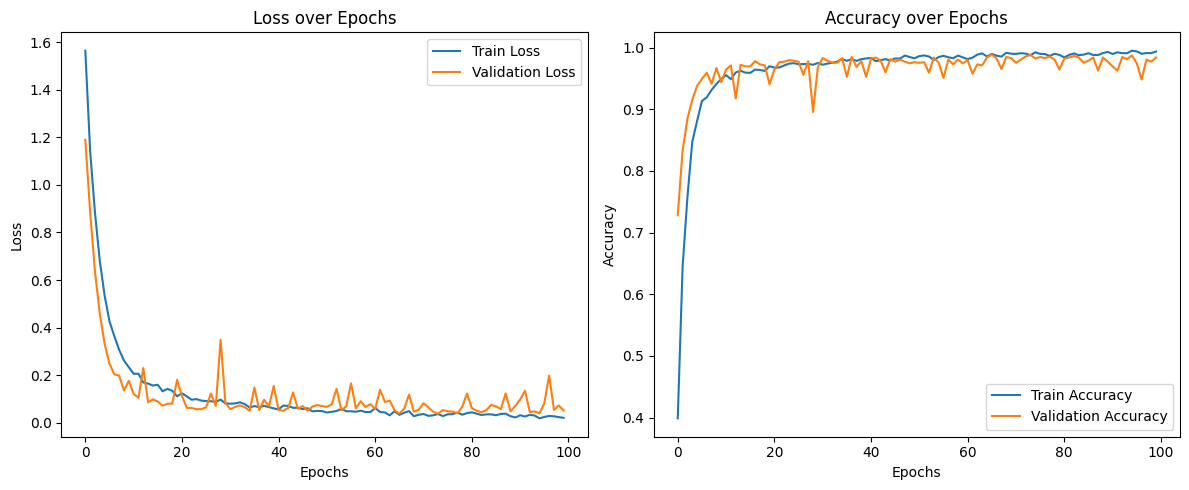

In [281]:
def main():
    data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
    save_path = os.path.join(os.getcwd(), 'model/best_model.pth')

    data_processor = DataLoaderPreprocessor(data_path)
    X_train_NN, X_val_NN, y_train_NN, y_val_NN = data_processor.load_and_preprocess_data()

    train_NN_loader, valid_NN_loader = data_processor.convert_to_tensor(X_train_NN, y_train_NN, X_val_NN, y_val_NN)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    MLP_model = MLP(input_dim=X_train_NN.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(MLP_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    trainer = Trainer(MLP_model, criterion, optimizer, device, scheduler, save_path=save_path)

    num_epochs = 100
    trainer.train(train_NN_loader, valid_NN_loader, num_epochs)
    trainer.plot_metrics()

if __name__ == "__main__":
    main()

### Test

In [282]:
class Tester:
    def __init__(self, model, test_path, scaler, device, best_model_path='best_model.pth'):
        self.model = model
        self.test_path = test_path
        self.scaler = scaler
        self.device = device
        self.best_model_path = best_model_path  # 최적 모델 경로
        self.model.to(self.device)

    def load_and_preprocess_data(self):
        # 테스트 데이터를 로드하고 전처리 수행
        NN_test = pd.read_csv(self.test_path)
        NN_test = NN_test.drop('subject', axis=1)  # 'subject' 열 제거
        NN_test['Activity'] = NN_test['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_test_NN = NN_test.drop(['Activity'], axis=1).to_numpy()
        y_test_NN = NN_test['Activity']

        # Test 데이터에 대해 스케일링 수행 (transform만 적용)
        # X_test_NN = self.scaler.fit_transform(X_test_NN)

        # Tensor 변환 후 GPU로 전달
        X_test_NN_tensor = torch.tensor(X_test_NN, dtype=torch.float32).to(self.device)
        y_test_NN_tensor = torch.tensor(y_test_NN.values, dtype=torch.long).to(self.device)

        return X_test_NN_tensor, y_test_NN_tensor

    def load_best_model(self):
        """저장된 최적의 모델을 로드"""
        self.model.load_state_dict(torch.load(self.best_model_path))
        print(f'Loaded best model from {self.best_model_path}')

    def test(self):
        """테스트 데이터로 모델 성능 평가"""
        # 최적의 모델 불러오기
        self.load_best_model()

        # 모델 평가 모드로 전환
        self.model.eval()

        # 테스트 데이터를 로드하고 전처리
        X_test_NN_tensor, y_test_NN_tensor = self.load_and_preprocess_data()

        # 예측 및 정확도 계산
        with torch.no_grad():
            # 모델로 예측값 계산 (softmax 사용 안 함)
            outputs = self.model(X_test_NN_tensor).squeeze()

            # argmax를 통해 가장 높은 값을 예측된 클래스로 추출
            predicted = torch.argmax(outputs, dim=1)

            # 예측값과 실제값 비교하여 정확도 계산
            correct = (predicted == y_test_NN_tensor).sum().item()
            total = y_test_NN_tensor.size(0)

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
        return accuracy


In [283]:
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

NN_test = pd.read_csv(test_path)
X_test_NN = NN_test.drop(['subject', 'Activity'], axis=1)

input_dim = X_test_NN.shape[1]
pretrained_MLP = MLP(input_dim=input_dim)

tester = Tester(pretrained_MLP, test_path, scaler, device, best_model_path=os.path.join(os.getcwd(), 'model/best_model.pth'))
tester.test()

Loaded best model from /Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_model.pth
Test Accuracy: 0.9905


0.990482664853841

## StandardScaler MLP

In [310]:
class ScalerDataLoaderPreprocessor:
    def __init__(self, file_path, scaler):
        self.file_path = file_path
        self.scaler = scaler

    def load_and_preprocess_data(self):
        NN_data = pd.read_csv(self.file_path)
        NN_data = NN_data.drop('subject', axis=1)
        
        NN_data['Activity'] = NN_data['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_NN = NN_data.drop('Activity', axis=1)
        y_NN = NN_data['Activity']

        X_NN = self.scaler.fit_transform(X_NN)

        X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(
            X_NN, y_NN, test_size=0.2, random_state=42, stratify=y_NN)

        return X_train_NN, X_val_NN, y_train_NN, y_val_NN

    def convert_to_tensor(self, X_train_NN, y_train_NN, X_val_NN, y_val_NN):
        X_train_NN_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
        y_train_NN_tensor = torch.tensor(y_train_NN.values, dtype=torch.float32)
        X_val_NN_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
        y_val_NN_tensor = torch.tensor(y_val_NN.values, dtype=torch.float32)

        train_NN_dataset = TensorDataset(X_train_NN_tensor, y_train_NN_tensor)
        valid_NN_dataset = TensorDataset(X_val_NN_tensor, y_val_NN_tensor)
        train_NN_loader = DataLoader(train_NN_dataset, batch_size=32, shuffle=True)
        valid_NN_loader = DataLoader(valid_NN_dataset, batch_size=32, shuffle=False)

        return train_NN_loader, valid_NN_loader
    

class ScalerTrainer:
    def __init__(self, model, criterion, optimizer, num_epochs, device, scheduler, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.num_epochs = num_epochs
        self.scheduler = scheduler
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        self.best_accuracy = 0  # 최적 성능 기록
        self.save_path = save_path  # 모델 저장 경로

    def scaler_train(self, train_NN_loader, valid_NN_loader):
        self.model.to(self.device)

        for epoch in range(self.num_epochs):
            # print(f"Epoch {epoch+1}/{self.num_epochs} START") 
            self.model.train()
            running_loss = 0
            correct_train = 0
            total_train = 0

            with tqdm(total=len(train_NN_loader), desc=f'Epoch {epoch+1}/{self.num_epochs}', unit='batch') as pbar:
                for batch_X, batch_y in train_NN_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    self.optimizer.zero_grad()

                    # 모델에 입력값을 전달하여 예측값 계산 (softmax 없이 logits 사용)
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)  # CrossEntropyLoss는 logits를 기대

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    
                    # argmax로 예측 클래스 계산
                    predicted = torch.argmax(outputs, dim=1)
                    total_train += batch_y.size(0)
                    correct_train += (predicted == batch_y).sum().item()

                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            epoch_train_loss = running_loss / len(train_NN_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(train_accuracy)

            # 평가 및 best model 저장
            self.evaluate_and_save_best(valid_NN_loader, epoch)

    def evaluate_and_save_best(self, valid_NN_loader, epoch):
        self.model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_X, batch_y in valid_NN_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                # 모델에 입력값을 전달하여 예측값 계산
                outputs = self.model(batch_X)
                valid_loss += self.criterion(outputs, batch_y).item()
                
                # argmax로 예측 클래스 계산
                predicted = torch.argmax(outputs, dim=1)
                total_valid += batch_y.size(0)
                correct_valid += (predicted == batch_y).sum().item()

        epoch_valid_loss = valid_loss / len(valid_NN_loader)
        valid_accuracy = correct_valid / total_valid
        self.valid_losses.append(epoch_valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}], Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

        # 최고 검증 정확도 갱신 시 모델 저장
        if valid_accuracy > self.best_accuracy:
            self.best_accuracy = valid_accuracy
            self.save_model()

    def save_model(self):
        """최고 성능을 기록한 모델을 저장"""
        torch.save(self.model.state_dict(), self.save_path)
        print(f"Best model saved with accuracy: {self.best_accuracy:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [311]:
NN_scaler = StandardScaler()

Epoch 1/150: 100%|██████████| 147/147 [00:02<00:00, 53.22batch/s, loss=1.47]


Epoch [1], Validation Loss: 1.3953, Validation Accuracy: 0.6602
Best model saved with accuracy: 0.6602


Epoch 2/150: 100%|██████████| 147/147 [00:02<00:00, 52.53batch/s, loss=1.04] 


Epoch [2], Validation Loss: 0.9774, Validation Accuracy: 0.7553
Best model saved with accuracy: 0.7553


Epoch 3/150: 100%|██████████| 147/147 [00:02<00:00, 56.09batch/s, loss=0.982]


Epoch [3], Validation Loss: 0.6957, Validation Accuracy: 0.7859
Best model saved with accuracy: 0.7859


Epoch 4/150: 100%|██████████| 147/147 [00:02<00:00, 56.30batch/s, loss=0.63] 


Epoch [4], Validation Loss: 0.5498, Validation Accuracy: 0.8165
Best model saved with accuracy: 0.8165


Epoch 5/150: 100%|██████████| 147/147 [00:02<00:00, 57.24batch/s, loss=0.705]


Epoch [5], Validation Loss: 0.4392, Validation Accuracy: 0.8513
Best model saved with accuracy: 0.8513


Epoch 6/150: 100%|██████████| 147/147 [00:02<00:00, 56.74batch/s, loss=0.506]


Epoch [6], Validation Loss: 0.3540, Validation Accuracy: 0.9261
Best model saved with accuracy: 0.9261


Epoch 7/150: 100%|██████████| 147/147 [00:02<00:00, 57.68batch/s, loss=0.369]


Epoch [7], Validation Loss: 0.2819, Validation Accuracy: 0.9473
Best model saved with accuracy: 0.9473


Epoch 8/150: 100%|██████████| 147/147 [00:02<00:00, 56.37batch/s, loss=0.327]


Epoch [8], Validation Loss: 0.2148, Validation Accuracy: 0.9516
Best model saved with accuracy: 0.9516


Epoch 9/150: 100%|██████████| 147/147 [00:02<00:00, 57.40batch/s, loss=0.148]


Epoch [9], Validation Loss: 0.1770, Validation Accuracy: 0.9584
Best model saved with accuracy: 0.9584


Epoch 10/150: 100%|██████████| 147/147 [00:02<00:00, 56.73batch/s, loss=0.559]


Epoch [10], Validation Loss: 0.1478, Validation Accuracy: 0.9686
Best model saved with accuracy: 0.9686


Epoch 11/150: 100%|██████████| 147/147 [00:02<00:00, 53.45batch/s, loss=0.146]


Epoch [11], Validation Loss: 0.1252, Validation Accuracy: 0.9669


Epoch 12/150: 100%|██████████| 147/147 [00:02<00:00, 58.40batch/s, loss=0.282] 


Epoch [12], Validation Loss: 0.1138, Validation Accuracy: 0.9686


Epoch 13/150: 100%|██████████| 147/147 [00:02<00:00, 58.04batch/s, loss=0.0836]


Epoch [13], Validation Loss: 0.1026, Validation Accuracy: 0.9711
Best model saved with accuracy: 0.9711


Epoch 14/150: 100%|██████████| 147/147 [00:02<00:00, 58.01batch/s, loss=0.197] 


Epoch [14], Validation Loss: 0.1013, Validation Accuracy: 0.9686


Epoch 15/150: 100%|██████████| 147/147 [00:02<00:00, 57.62batch/s, loss=0.124] 


Epoch [15], Validation Loss: 0.0938, Validation Accuracy: 0.9686


Epoch 16/150: 100%|██████████| 147/147 [00:02<00:00, 55.32batch/s, loss=0.0999]


Epoch [16], Validation Loss: 0.0921, Validation Accuracy: 0.9711


Epoch 17/150: 100%|██████████| 147/147 [00:02<00:00, 56.96batch/s, loss=0.105] 


Epoch [17], Validation Loss: 0.0824, Validation Accuracy: 0.9745
Best model saved with accuracy: 0.9745


Epoch 18/150: 100%|██████████| 147/147 [00:02<00:00, 57.11batch/s, loss=0.532] 


Epoch [18], Validation Loss: 0.0802, Validation Accuracy: 0.9720


Epoch 19/150: 100%|██████████| 147/147 [00:02<00:00, 53.95batch/s, loss=0.212] 


Epoch [19], Validation Loss: 0.0768, Validation Accuracy: 0.9728


Epoch 20/150: 100%|██████████| 147/147 [00:02<00:00, 57.64batch/s, loss=0.0656]


Epoch [20], Validation Loss: 0.0801, Validation Accuracy: 0.9728


Epoch 21/150: 100%|██████████| 147/147 [00:02<00:00, 57.24batch/s, loss=0.0856]


Epoch [21], Validation Loss: 0.0723, Validation Accuracy: 0.9762
Best model saved with accuracy: 0.9762


Epoch 22/150: 100%|██████████| 147/147 [00:02<00:00, 55.99batch/s, loss=0.045] 


Epoch [22], Validation Loss: 0.0766, Validation Accuracy: 0.9728


Epoch 23/150: 100%|██████████| 147/147 [00:02<00:00, 58.31batch/s, loss=0.127] 


Epoch [23], Validation Loss: 0.0753, Validation Accuracy: 0.9720


Epoch 24/150: 100%|██████████| 147/147 [00:02<00:00, 60.55batch/s, loss=0.158] 


Epoch [24], Validation Loss: 0.0748, Validation Accuracy: 0.9737


Epoch 25/150: 100%|██████████| 147/147 [00:02<00:00, 55.88batch/s, loss=0.106] 


Epoch [25], Validation Loss: 0.0923, Validation Accuracy: 0.9686


Epoch 26/150: 100%|██████████| 147/147 [00:02<00:00, 55.06batch/s, loss=0.152] 


Epoch [26], Validation Loss: 0.0782, Validation Accuracy: 0.9720


Epoch 27/150: 100%|██████████| 147/147 [00:02<00:00, 57.83batch/s, loss=0.0959]


Epoch [27], Validation Loss: 0.0697, Validation Accuracy: 0.9771
Best model saved with accuracy: 0.9771


Epoch 28/150: 100%|██████████| 147/147 [00:02<00:00, 55.80batch/s, loss=0.185] 


Epoch [28], Validation Loss: 0.0606, Validation Accuracy: 0.9788
Best model saved with accuracy: 0.9788


Epoch 29/150: 100%|██████████| 147/147 [00:02<00:00, 58.35batch/s, loss=0.0232]


Epoch [29], Validation Loss: 0.0639, Validation Accuracy: 0.9771


Epoch 30/150: 100%|██████████| 147/147 [00:02<00:00, 56.97batch/s, loss=0.16]  


Epoch [30], Validation Loss: 0.0616, Validation Accuracy: 0.9796
Best model saved with accuracy: 0.9796


Epoch 31/150: 100%|██████████| 147/147 [00:02<00:00, 56.33batch/s, loss=0.104] 


Epoch [31], Validation Loss: 0.0600, Validation Accuracy: 0.9796


Epoch 32/150: 100%|██████████| 147/147 [00:02<00:00, 54.84batch/s, loss=0.0205]


Epoch [32], Validation Loss: 0.0654, Validation Accuracy: 0.9788


Epoch 33/150: 100%|██████████| 147/147 [00:02<00:00, 58.63batch/s, loss=0.0286] 


Epoch [33], Validation Loss: 0.0692, Validation Accuracy: 0.9771


Epoch 34/150: 100%|██████████| 147/147 [00:02<00:00, 58.15batch/s, loss=0.0727]


Epoch [34], Validation Loss: 0.0690, Validation Accuracy: 0.9779


Epoch 35/150: 100%|██████████| 147/147 [00:02<00:00, 58.53batch/s, loss=0.0244]


Epoch [35], Validation Loss: 0.0713, Validation Accuracy: 0.9788


Epoch 36/150: 100%|██████████| 147/147 [00:02<00:00, 57.51batch/s, loss=0.0509]


Epoch [36], Validation Loss: 0.0858, Validation Accuracy: 0.9728


Epoch 37/150: 100%|██████████| 147/147 [00:02<00:00, 56.46batch/s, loss=0.0469]


Epoch [37], Validation Loss: 0.0619, Validation Accuracy: 0.9779


Epoch 38/150: 100%|██████████| 147/147 [00:02<00:00, 58.09batch/s, loss=0.142] 


Epoch [38], Validation Loss: 0.0734, Validation Accuracy: 0.9737


Epoch 39/150: 100%|██████████| 147/147 [00:02<00:00, 58.51batch/s, loss=0.152]  


Epoch [39], Validation Loss: 0.0657, Validation Accuracy: 0.9745


Epoch 40/150: 100%|██████████| 147/147 [00:02<00:00, 57.52batch/s, loss=0.0312]


Epoch [40], Validation Loss: 0.1019, Validation Accuracy: 0.9711


Epoch 41/150: 100%|██████████| 147/147 [00:02<00:00, 56.57batch/s, loss=0.0258] 


Epoch [41], Validation Loss: 0.0715, Validation Accuracy: 0.9745


Epoch 42/150: 100%|██████████| 147/147 [00:02<00:00, 56.73batch/s, loss=0.0146]


Epoch [42], Validation Loss: 0.0605, Validation Accuracy: 0.9805
Best model saved with accuracy: 0.9805


Epoch 43/150: 100%|██████████| 147/147 [00:02<00:00, 55.26batch/s, loss=0.147]  


Epoch [43], Validation Loss: 0.0554, Validation Accuracy: 0.9813
Best model saved with accuracy: 0.9813


Epoch 44/150: 100%|██████████| 147/147 [00:02<00:00, 58.19batch/s, loss=0.184] 


Epoch [44], Validation Loss: 0.0607, Validation Accuracy: 0.9805


Epoch 45/150: 100%|██████████| 147/147 [00:02<00:00, 57.89batch/s, loss=0.0264]


Epoch [45], Validation Loss: 0.0647, Validation Accuracy: 0.9788


Epoch 46/150: 100%|██████████| 147/147 [00:02<00:00, 56.97batch/s, loss=0.078]  


Epoch [46], Validation Loss: 0.0535, Validation Accuracy: 0.9805


Epoch 47/150: 100%|██████████| 147/147 [00:02<00:00, 57.86batch/s, loss=0.0139] 


Epoch [47], Validation Loss: 0.0495, Validation Accuracy: 0.9813


Epoch 48/150: 100%|██████████| 147/147 [00:02<00:00, 54.25batch/s, loss=0.0182]


Epoch [48], Validation Loss: 0.0507, Validation Accuracy: 0.9813


Epoch 49/150: 100%|██████████| 147/147 [00:02<00:00, 56.76batch/s, loss=0.0838] 


Epoch [49], Validation Loss: 0.0516, Validation Accuracy: 0.9830
Best model saved with accuracy: 0.9830


Epoch 50/150: 100%|██████████| 147/147 [00:02<00:00, 56.41batch/s, loss=0.0215] 


Epoch [50], Validation Loss: 0.0539, Validation Accuracy: 0.9788


Epoch 51/150: 100%|██████████| 147/147 [00:02<00:00, 57.84batch/s, loss=0.0352] 


Epoch [51], Validation Loss: 0.0555, Validation Accuracy: 0.9822


Epoch 52/150: 100%|██████████| 147/147 [00:02<00:00, 58.38batch/s, loss=0.0146] 


Epoch [52], Validation Loss: 0.0537, Validation Accuracy: 0.9813


Epoch 53/150: 100%|██████████| 147/147 [00:02<00:00, 54.62batch/s, loss=0.189]  


Epoch [53], Validation Loss: 0.0684, Validation Accuracy: 0.9805


Epoch 54/150: 100%|██████████| 147/147 [00:02<00:00, 56.68batch/s, loss=0.0548] 


Epoch [54], Validation Loss: 0.0584, Validation Accuracy: 0.9805


Epoch 55/150: 100%|██████████| 147/147 [00:02<00:00, 54.39batch/s, loss=0.0297] 


Epoch [55], Validation Loss: 0.0527, Validation Accuracy: 0.9813


Epoch 56/150: 100%|██████████| 147/147 [00:02<00:00, 58.27batch/s, loss=0.161]  


Epoch [56], Validation Loss: 0.0622, Validation Accuracy: 0.9779


Epoch 57/150: 100%|██████████| 147/147 [00:02<00:00, 57.57batch/s, loss=0.0303] 


Epoch [57], Validation Loss: 0.0534, Validation Accuracy: 0.9813


Epoch 58/150: 100%|██████████| 147/147 [00:02<00:00, 56.24batch/s, loss=0.0131] 


Epoch [58], Validation Loss: 0.0690, Validation Accuracy: 0.9788


Epoch 59/150: 100%|██████████| 147/147 [00:02<00:00, 56.41batch/s, loss=0.0447] 


Epoch [59], Validation Loss: 0.0550, Validation Accuracy: 0.9839
Best model saved with accuracy: 0.9839


Epoch 60/150: 100%|██████████| 147/147 [00:02<00:00, 56.75batch/s, loss=0.0677] 


Epoch [60], Validation Loss: 0.0898, Validation Accuracy: 0.9737


Epoch 61/150: 100%|██████████| 147/147 [00:02<00:00, 58.41batch/s, loss=0.201]  


Epoch [61], Validation Loss: 0.0485, Validation Accuracy: 0.9830


Epoch 62/150: 100%|██████████| 147/147 [00:02<00:00, 59.17batch/s, loss=0.0457] 


Epoch [62], Validation Loss: 0.0530, Validation Accuracy: 0.9796


Epoch 63/150: 100%|██████████| 147/147 [00:02<00:00, 53.66batch/s, loss=0.134]  


Epoch [63], Validation Loss: 0.0480, Validation Accuracy: 0.9847
Best model saved with accuracy: 0.9847


Epoch 64/150: 100%|██████████| 147/147 [00:02<00:00, 55.97batch/s, loss=0.149]  


Epoch [64], Validation Loss: 0.0505, Validation Accuracy: 0.9822


Epoch 65/150: 100%|██████████| 147/147 [00:02<00:00, 57.09batch/s, loss=0.22]   


Epoch [65], Validation Loss: 0.0709, Validation Accuracy: 0.9779


Epoch 66/150: 100%|██████████| 147/147 [00:02<00:00, 56.87batch/s, loss=0.00955]


Epoch [66], Validation Loss: 0.0490, Validation Accuracy: 0.9839


Epoch 67/150: 100%|██████████| 147/147 [00:02<00:00, 58.88batch/s, loss=0.0126] 


Epoch [67], Validation Loss: 0.0479, Validation Accuracy: 0.9847


Epoch 68/150: 100%|██████████| 147/147 [00:02<00:00, 55.50batch/s, loss=0.0086] 


Epoch [68], Validation Loss: 0.0524, Validation Accuracy: 0.9830


Epoch 69/150: 100%|██████████| 147/147 [00:02<00:00, 57.81batch/s, loss=0.00636]


Epoch [69], Validation Loss: 0.0490, Validation Accuracy: 0.9839


Epoch 70/150: 100%|██████████| 147/147 [00:02<00:00, 57.70batch/s, loss=0.0161] 


Epoch [70], Validation Loss: 0.0503, Validation Accuracy: 0.9830


Epoch 71/150: 100%|██████████| 147/147 [00:02<00:00, 56.08batch/s, loss=0.154]  


Epoch [71], Validation Loss: 0.0459, Validation Accuracy: 0.9873
Best model saved with accuracy: 0.9873


Epoch 72/150: 100%|██████████| 147/147 [00:02<00:00, 58.03batch/s, loss=0.106]  


Epoch [72], Validation Loss: 0.0479, Validation Accuracy: 0.9847


Epoch 73/150: 100%|██████████| 147/147 [00:02<00:00, 56.72batch/s, loss=0.0612] 


Epoch [73], Validation Loss: 0.0512, Validation Accuracy: 0.9839


Epoch 74/150: 100%|██████████| 147/147 [00:02<00:00, 56.00batch/s, loss=0.00544]


Epoch [74], Validation Loss: 0.0449, Validation Accuracy: 0.9839


Epoch 75/150: 100%|██████████| 147/147 [00:02<00:00, 57.06batch/s, loss=0.0506] 


Epoch [75], Validation Loss: 0.0585, Validation Accuracy: 0.9813


Epoch 76/150: 100%|██████████| 147/147 [00:02<00:00, 57.21batch/s, loss=0.0159] 


Epoch [76], Validation Loss: 0.0475, Validation Accuracy: 0.9856


Epoch 77/150: 100%|██████████| 147/147 [00:02<00:00, 58.85batch/s, loss=0.0844] 


Epoch [77], Validation Loss: 0.0595, Validation Accuracy: 0.9830


Epoch 78/150: 100%|██████████| 147/147 [00:02<00:00, 58.00batch/s, loss=0.00677]


Epoch [78], Validation Loss: 0.0634, Validation Accuracy: 0.9796


Epoch 79/150: 100%|██████████| 147/147 [00:02<00:00, 57.24batch/s, loss=0.00621]


Epoch [79], Validation Loss: 0.0681, Validation Accuracy: 0.9779


Epoch 80/150: 100%|██████████| 147/147 [00:02<00:00, 57.95batch/s, loss=0.0137] 


Epoch [80], Validation Loss: 0.0501, Validation Accuracy: 0.9847


Epoch 81/150: 100%|██████████| 147/147 [00:02<00:00, 57.33batch/s, loss=0.00919]


Epoch [81], Validation Loss: 0.0507, Validation Accuracy: 0.9813


Epoch 82/150: 100%|██████████| 147/147 [00:02<00:00, 57.47batch/s, loss=0.0205] 


Epoch [82], Validation Loss: 0.0512, Validation Accuracy: 0.9830


Epoch 83/150: 100%|██████████| 147/147 [00:02<00:00, 53.90batch/s, loss=0.00963]


Epoch [83], Validation Loss: 0.0483, Validation Accuracy: 0.9864


Epoch 84/150: 100%|██████████| 147/147 [00:02<00:00, 57.14batch/s, loss=0.00837]


Epoch [84], Validation Loss: 0.0531, Validation Accuracy: 0.9830


Epoch 85/150: 100%|██████████| 147/147 [00:02<00:00, 57.76batch/s, loss=0.00495]


Epoch [85], Validation Loss: 0.0442, Validation Accuracy: 0.9847


Epoch 86/150: 100%|██████████| 147/147 [00:02<00:00, 55.60batch/s, loss=0.0903] 


Epoch [86], Validation Loss: 0.0486, Validation Accuracy: 0.9830


Epoch 87/150: 100%|██████████| 147/147 [00:02<00:00, 57.54batch/s, loss=0.126]  


Epoch [87], Validation Loss: 0.0645, Validation Accuracy: 0.9788


Epoch 88/150: 100%|██████████| 147/147 [00:02<00:00, 56.08batch/s, loss=0.00536]


Epoch [88], Validation Loss: 0.0551, Validation Accuracy: 0.9830


Epoch 89/150: 100%|██████████| 147/147 [00:02<00:00, 56.71batch/s, loss=0.0307] 


Epoch [89], Validation Loss: 0.0470, Validation Accuracy: 0.9856


Epoch 90/150: 100%|██████████| 147/147 [00:02<00:00, 58.01batch/s, loss=0.00634]


Epoch [90], Validation Loss: 0.0549, Validation Accuracy: 0.9847


Epoch 91/150: 100%|██████████| 147/147 [00:02<00:00, 57.92batch/s, loss=0.0034] 


Epoch [91], Validation Loss: 0.0518, Validation Accuracy: 0.9847


Epoch 92/150: 100%|██████████| 147/147 [00:02<00:00, 57.61batch/s, loss=0.0251] 


Epoch [92], Validation Loss: 0.0600, Validation Accuracy: 0.9805


Epoch 93/150: 100%|██████████| 147/147 [00:02<00:00, 56.73batch/s, loss=0.0114] 


Epoch [93], Validation Loss: 0.0645, Validation Accuracy: 0.9779


Epoch 94/150: 100%|██████████| 147/147 [00:02<00:00, 58.18batch/s, loss=0.00895]


Epoch [94], Validation Loss: 0.0488, Validation Accuracy: 0.9864


Epoch 95/150: 100%|██████████| 147/147 [00:02<00:00, 57.50batch/s, loss=0.0331] 


Epoch [95], Validation Loss: 0.0439, Validation Accuracy: 0.9881
Best model saved with accuracy: 0.9881


Epoch 96/150: 100%|██████████| 147/147 [00:02<00:00, 58.25batch/s, loss=0.153]  


Epoch [96], Validation Loss: 0.0616, Validation Accuracy: 0.9813


Epoch 97/150: 100%|██████████| 147/147 [00:02<00:00, 57.64batch/s, loss=0.00932]


Epoch [97], Validation Loss: 0.0522, Validation Accuracy: 0.9847


Epoch 98/150: 100%|██████████| 147/147 [00:02<00:00, 56.44batch/s, loss=0.0145] 


Epoch [98], Validation Loss: 0.0458, Validation Accuracy: 0.9856


Epoch 99/150: 100%|██████████| 147/147 [00:02<00:00, 55.17batch/s, loss=0.00927]


Epoch [99], Validation Loss: 0.0462, Validation Accuracy: 0.9873


Epoch 100/150: 100%|██████████| 147/147 [00:02<00:00, 58.36batch/s, loss=0.00387]


Epoch [100], Validation Loss: 0.0715, Validation Accuracy: 0.9788


Epoch 101/150: 100%|██████████| 147/147 [00:02<00:00, 58.09batch/s, loss=0.0111] 


Epoch [101], Validation Loss: 0.0475, Validation Accuracy: 0.9856


Epoch 102/150: 100%|██████████| 147/147 [00:02<00:00, 56.05batch/s, loss=0.00474]


Epoch [102], Validation Loss: 0.0598, Validation Accuracy: 0.9779


Epoch 103/150: 100%|██████████| 147/147 [00:02<00:00, 57.93batch/s, loss=0.0286] 


Epoch [103], Validation Loss: 0.0726, Validation Accuracy: 0.9788


Epoch 104/150: 100%|██████████| 147/147 [00:02<00:00, 57.19batch/s, loss=0.00266]


Epoch [104], Validation Loss: 0.0539, Validation Accuracy: 0.9847


Epoch 105/150: 100%|██████████| 147/147 [00:02<00:00, 59.27batch/s, loss=0.00249]


Epoch [105], Validation Loss: 0.0481, Validation Accuracy: 0.9873


Epoch 106/150: 100%|██████████| 147/147 [00:02<00:00, 59.89batch/s, loss=0.145]  


Epoch [106], Validation Loss: 0.0430, Validation Accuracy: 0.9864


Epoch 107/150: 100%|██████████| 147/147 [00:02<00:00, 57.79batch/s, loss=0.0123] 


Epoch [107], Validation Loss: 0.0653, Validation Accuracy: 0.9813


Epoch 108/150: 100%|██████████| 147/147 [00:02<00:00, 55.36batch/s, loss=0.066]  


Epoch [108], Validation Loss: 0.0455, Validation Accuracy: 0.9864


Epoch 109/150: 100%|██████████| 147/147 [00:02<00:00, 54.45batch/s, loss=0.0052] 


Epoch [109], Validation Loss: 0.0437, Validation Accuracy: 0.9873


Epoch 110/150: 100%|██████████| 147/147 [00:02<00:00, 59.33batch/s, loss=0.00278]


Epoch [110], Validation Loss: 0.0489, Validation Accuracy: 0.9856


Epoch 111/150: 100%|██████████| 147/147 [00:02<00:00, 56.17batch/s, loss=0.0118] 


Epoch [111], Validation Loss: 0.0478, Validation Accuracy: 0.9873


Epoch 112/150: 100%|██████████| 147/147 [00:02<00:00, 52.07batch/s, loss=0.00775]


Epoch [112], Validation Loss: 0.0592, Validation Accuracy: 0.9864


Epoch 113/150: 100%|██████████| 147/147 [00:02<00:00, 54.87batch/s, loss=0.00509]


Epoch [113], Validation Loss: 0.0509, Validation Accuracy: 0.9856


Epoch 114/150: 100%|██████████| 147/147 [00:02<00:00, 54.18batch/s, loss=0.0185] 


Epoch [114], Validation Loss: 0.0533, Validation Accuracy: 0.9839


Epoch 115/150: 100%|██████████| 147/147 [00:02<00:00, 53.77batch/s, loss=0.171]  


Epoch [115], Validation Loss: 0.0472, Validation Accuracy: 0.9881


Epoch 116/150: 100%|██████████| 147/147 [00:02<00:00, 55.79batch/s, loss=0.00313]


Epoch [116], Validation Loss: 0.0495, Validation Accuracy: 0.9881


Epoch 117/150: 100%|██████████| 147/147 [00:02<00:00, 54.08batch/s, loss=0.00362]


Epoch [117], Validation Loss: 0.0622, Validation Accuracy: 0.9830


Epoch 118/150: 100%|██████████| 147/147 [00:02<00:00, 52.76batch/s, loss=0.00567]


Epoch [118], Validation Loss: 0.0424, Validation Accuracy: 0.9881


Epoch 119/150: 100%|██████████| 147/147 [00:02<00:00, 53.26batch/s, loss=0.006]  


Epoch [119], Validation Loss: 0.0472, Validation Accuracy: 0.9873


Epoch 120/150: 100%|██████████| 147/147 [00:02<00:00, 54.72batch/s, loss=0.116]  


Epoch [120], Validation Loss: 0.0572, Validation Accuracy: 0.9856


Epoch 121/150: 100%|██████████| 147/147 [00:02<00:00, 49.85batch/s, loss=0.00447]


Epoch [121], Validation Loss: 0.0665, Validation Accuracy: 0.9788


Epoch 122/150: 100%|██████████| 147/147 [00:02<00:00, 58.31batch/s, loss=0.0567] 


Epoch [122], Validation Loss: 0.0571, Validation Accuracy: 0.9830


Epoch 123/150: 100%|██████████| 147/147 [00:02<00:00, 56.62batch/s, loss=0.00361]


Epoch [123], Validation Loss: 0.0773, Validation Accuracy: 0.9805


Epoch 124/150: 100%|██████████| 147/147 [00:02<00:00, 57.31batch/s, loss=0.0676] 


Epoch [124], Validation Loss: 0.0480, Validation Accuracy: 0.9847


Epoch 125/150: 100%|██████████| 147/147 [00:02<00:00, 53.29batch/s, loss=0.00203] 


Epoch [125], Validation Loss: 0.0466, Validation Accuracy: 0.9847


Epoch 126/150: 100%|██████████| 147/147 [00:02<00:00, 58.12batch/s, loss=0.00554] 


Epoch [126], Validation Loss: 0.0436, Validation Accuracy: 0.9873


Epoch 127/150: 100%|██████████| 147/147 [00:02<00:00, 56.40batch/s, loss=0.0034]  


Epoch [127], Validation Loss: 0.0565, Validation Accuracy: 0.9847


Epoch 128/150: 100%|██████████| 147/147 [00:02<00:00, 58.40batch/s, loss=0.00136]


Epoch [128], Validation Loss: 0.0484, Validation Accuracy: 0.9873


Epoch 129/150: 100%|██████████| 147/147 [00:02<00:00, 56.89batch/s, loss=0.0145] 


Epoch [129], Validation Loss: 0.0688, Validation Accuracy: 0.9813


Epoch 130/150: 100%|██████████| 147/147 [00:02<00:00, 55.53batch/s, loss=0.00432]


Epoch [130], Validation Loss: 0.0489, Validation Accuracy: 0.9864


Epoch 131/150: 100%|██████████| 147/147 [00:02<00:00, 59.99batch/s, loss=0.0709] 


Epoch [131], Validation Loss: 0.0537, Validation Accuracy: 0.9847


Epoch 132/150: 100%|██████████| 147/147 [00:02<00:00, 58.11batch/s, loss=0.00615] 


Epoch [132], Validation Loss: 0.0478, Validation Accuracy: 0.9873


Epoch 133/150: 100%|██████████| 147/147 [00:02<00:00, 59.61batch/s, loss=0.127]   


Epoch [133], Validation Loss: 0.0505, Validation Accuracy: 0.9864


Epoch 134/150: 100%|██████████| 147/147 [00:02<00:00, 55.06batch/s, loss=0.00551]


Epoch [134], Validation Loss: 0.0456, Validation Accuracy: 0.9864


Epoch 135/150: 100%|██████████| 147/147 [00:02<00:00, 60.09batch/s, loss=0.00146] 


Epoch [135], Validation Loss: 0.0513, Validation Accuracy: 0.9856


Epoch 136/150: 100%|██████████| 147/147 [00:02<00:00, 58.43batch/s, loss=0.00339]


Epoch [136], Validation Loss: 0.0526, Validation Accuracy: 0.9856


Epoch 137/150: 100%|██████████| 147/147 [00:02<00:00, 58.72batch/s, loss=0.0168] 


Epoch [137], Validation Loss: 0.0619, Validation Accuracy: 0.9830


Epoch 138/150: 100%|██████████| 147/147 [00:02<00:00, 55.68batch/s, loss=0.00288]


Epoch [138], Validation Loss: 0.0479, Validation Accuracy: 0.9847


Epoch 139/150: 100%|██████████| 147/147 [00:02<00:00, 59.00batch/s, loss=0.0022]  


Epoch [139], Validation Loss: 0.0543, Validation Accuracy: 0.9839


Epoch 140/150: 100%|██████████| 147/147 [00:02<00:00, 53.89batch/s, loss=0.00712] 


Epoch [140], Validation Loss: 0.0537, Validation Accuracy: 0.9873


Epoch 141/150: 100%|██████████| 147/147 [00:02<00:00, 57.79batch/s, loss=0.0123]  


Epoch [141], Validation Loss: 0.0498, Validation Accuracy: 0.9847


Epoch 142/150: 100%|██████████| 147/147 [00:02<00:00, 57.37batch/s, loss=0.0244] 


Epoch [142], Validation Loss: 0.0422, Validation Accuracy: 0.9856


Epoch 143/150: 100%|██████████| 147/147 [00:02<00:00, 53.04batch/s, loss=0.00536] 


Epoch [143], Validation Loss: 0.0724, Validation Accuracy: 0.9822


Epoch 144/150: 100%|██████████| 147/147 [00:02<00:00, 60.27batch/s, loss=0.00854] 


Epoch [144], Validation Loss: 0.0439, Validation Accuracy: 0.9881


Epoch 145/150: 100%|██████████| 147/147 [00:02<00:00, 58.45batch/s, loss=0.00128] 


Epoch [145], Validation Loss: 0.0514, Validation Accuracy: 0.9847


Epoch 146/150: 100%|██████████| 147/147 [00:02<00:00, 59.08batch/s, loss=0.00251] 


Epoch [146], Validation Loss: 0.0481, Validation Accuracy: 0.9873


Epoch 147/150: 100%|██████████| 147/147 [00:02<00:00, 54.53batch/s, loss=0.00259] 


Epoch [147], Validation Loss: 0.0490, Validation Accuracy: 0.9847


Epoch 148/150: 100%|██████████| 147/147 [00:02<00:00, 58.57batch/s, loss=0.00268]


Epoch [148], Validation Loss: 0.0483, Validation Accuracy: 0.9881


Epoch 149/150: 100%|██████████| 147/147 [00:02<00:00, 55.73batch/s, loss=0.00132] 


Epoch [149], Validation Loss: 0.0437, Validation Accuracy: 0.9881


Epoch 150/150: 100%|██████████| 147/147 [00:02<00:00, 55.61batch/s, loss=0.00114] 


Epoch [150], Validation Loss: 0.0559, Validation Accuracy: 0.9847


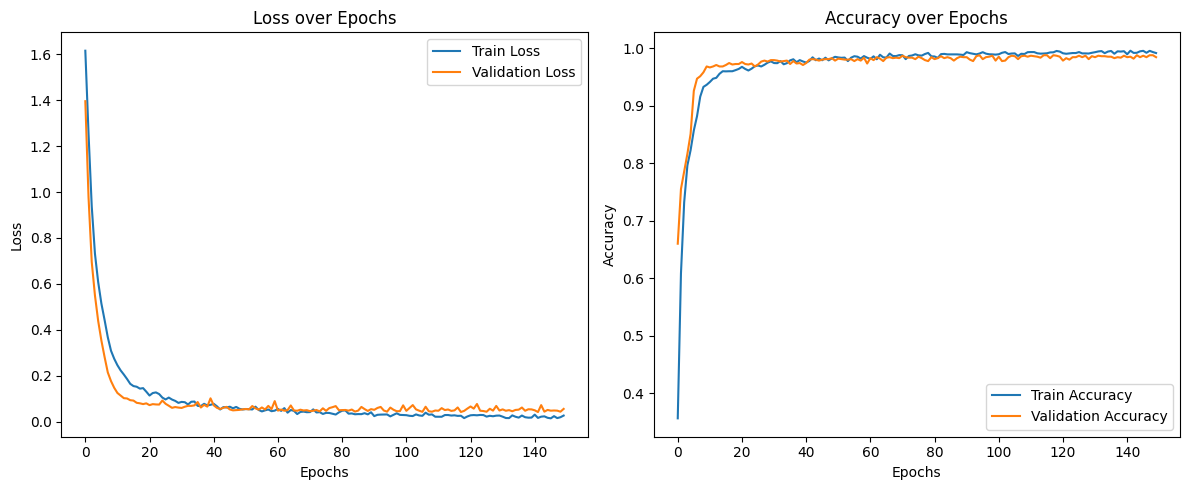

In [312]:
def scaler_main():
    data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
    save_path = os.path.join(os.getcwd(), 'model/best_scaled_model.pth')

    data_processor = ScalerDataLoaderPreprocessor(data_path, NN_scaler)
    X_train_NN, X_val_NN, y_train_NN, y_val_NN = data_processor.load_and_preprocess_data()

    train_NN_loader, valid_NN_loader = data_processor.convert_to_tensor(X_train_NN, y_train_NN, X_val_NN, y_val_NN)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    MLP_model = MLP(input_dim=X_train_NN.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(MLP_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    num_epochs = 150
    trainer = ScalerTrainer(model=MLP_model, criterion=criterion, 
                            optimizer=optimizer, num_epochs=num_epochs,
                            device=device, scheduler=scheduler, save_path=save_path
                            )
    trainer.scaler_train(train_NN_loader, valid_NN_loader)
    trainer.plot_metrics()

if __name__ == "__main__":
    scaler_main()

In [313]:
class ScalerTester:
    def __init__(self, model, test_path, scaler, device, best_model_path='best_model.pth'):
        self.model = model
        self.test_path = test_path
        self.scaler = scaler
        self.device = device
        self.best_model_path = best_model_path  # 최적 모델 경로
        self.model.to(self.device)

    def load_and_preprocess_data(self):
        # 테스트 데이터를 로드하고 전처리 수행
        NN_test = pd.read_csv(self.test_path)
        NN_test = NN_test.drop('subject', axis=1)  # 'subject' 열 제거
        NN_test['Activity'] = NN_test['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_test_NN = NN_test.drop(['Activity'], axis=1)
        y_test_NN = NN_test['Activity']

        # Test 데이터에 대해 스케일링 수행 (transform만 적용)
        X_test_NN = self.scaler.transform(X_test_NN)

        # Tensor 변환 후 GPU로 전달
        X_test_NN_tensor = torch.tensor(X_test_NN, dtype=torch.float32).to(self.device)
        y_test_NN_tensor = torch.tensor(y_test_NN.values, dtype=torch.long).to(self.device)

        return X_test_NN_tensor, y_test_NN_tensor

    def load_best_model(self):
        """저장된 최적의 모델을 로드"""
        self.model.load_state_dict(torch.load(self.best_model_path))
        print(f'Loaded best model from {self.best_model_path}')

    def test(self):
        """테스트 데이터로 모델 성능 평가"""
        # 최적의 모델 불러오기
        self.load_best_model()

        # 모델 평가 모드로 전환
        self.model.eval()

        # 테스트 데이터를 로드하고 전처리
        X_test_NN_tensor, y_test_NN_tensor = self.load_and_preprocess_data()

        # 예측 및 정확도 계산
        with torch.no_grad():
            # 모델로 예측값 계산 (softmax 사용 안 함)
            outputs = self.model(X_test_NN_tensor).squeeze()

            # argmax를 통해 가장 높은 값을 예측된 클래스로 추출
            predicted = torch.argmax(outputs, dim=1)

            # 예측값과 실제값 비교하여 정확도 계산
            correct = (predicted == y_test_NN_tensor).sum().item()
            total = y_test_NN_tensor.size(0)

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
        return accuracy
    
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

NN_test = pd.read_csv(test_path)
X_test_NN = NN_test.drop(['subject', 'Activity'], axis=1)

input_dim = X_test_NN.shape[1]
pretrained_MLP = MLP(input_dim=input_dim)

tester = ScalerTester(pretrained_MLP, test_path, NN_scaler, device, best_model_path=os.path.join(os.getcwd(), 'model/best_scaled_model.pth'))
tester.test()


Loaded best model from /Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_scaled_model.pth
Test Accuracy: 0.9857


0.9857239972807614

## 1DCNN

In [334]:
class CNNScalerDataLoaderPreprocessor:
    def __init__(self, file_path, scaler):
        self.file_path = file_path
        self.scaler = scaler

    def load_and_preprocess_data(self):
        NN_data = pd.read_csv(self.file_path)
        NN_data = NN_data.drop('subject', axis=1)
        
        NN_data['Activity'] = NN_data['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_NN = NN_data.drop('Activity', axis=1)
        y_NN = NN_data['Activity']

        X_NN = self.scaler.fit_transform(X_NN)

        X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(
            X_NN, y_NN, test_size=0.2, random_state=42, stratify=y_NN)

        return X_train_NN, X_val_NN, y_train_NN, y_val_NN

    def convert_to_tensor(self, X_train_NN, y_train_NN, X_val_NN, y_val_NN):
        X_train_NN_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
        y_train_NN_tensor = torch.tensor(y_train_NN.values, dtype=torch.float32)
        X_val_NN_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
        y_val_NN_tensor = torch.tensor(y_val_NN.values, dtype=torch.float32)

        train_NN_dataset = TensorDataset(X_train_NN_tensor, y_train_NN_tensor)
        valid_NN_dataset = TensorDataset(X_val_NN_tensor, y_val_NN_tensor)
        train_NN_loader = DataLoader(train_NN_dataset, batch_size=32, shuffle=True)
        valid_NN_loader = DataLoader(valid_NN_dataset, batch_size=32, shuffle=False)

        return train_NN_loader, valid_NN_loader
    

class CNNScalerTrainer:
    def __init__(self, model, criterion, optimizer, num_epochs, device, scheduler, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.num_epochs = num_epochs
        self.scheduler = scheduler
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        self.best_accuracy = 0  # 최적 성능 기록
        self.save_path = save_path  # 모델 저장 경로

    def scaler_train(self, train_NN_loader, valid_NN_loader):
        self.model.to(self.device)

        for epoch in range(self.num_epochs):
            # print(f"Epoch {epoch+1}/{self.num_epochs} START") 
            self.model.train()
            running_loss = 0
            correct_train = 0
            total_train = 0

            with tqdm(total=len(train_NN_loader), desc=f'Epoch {epoch+1}/{self.num_epochs}', unit='batch') as pbar:
                for batch_X, batch_y in train_NN_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    self.optimizer.zero_grad()

                    # 모델에 입력값을 전달하여 예측값 계산 (softmax 없이 logits 사용)
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)  # CrossEntropyLoss는 logits를 기대

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    
                    # argmax로 예측 클래스 계산
                    predicted = torch.argmax(outputs, dim=1)
                    total_train += batch_y.size(0)
                    correct_train += (predicted == batch_y).sum().item()

                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            epoch_train_loss = running_loss / len(train_NN_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(train_accuracy)

            # 평가 및 best model 저장
            self.evaluate_and_save_best(valid_NN_loader, epoch)

    def evaluate_and_save_best(self, valid_NN_loader, epoch):
        self.model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_X, batch_y in valid_NN_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                # 모델에 입력값을 전달하여 예측값 계산
                outputs = self.model(batch_X)
                valid_loss += self.criterion(outputs, batch_y).item()
                
                # argmax로 예측 클래스 계산
                predicted = torch.argmax(outputs, dim=1)
                total_valid += batch_y.size(0)
                correct_valid += (predicted == batch_y).sum().item()

        epoch_valid_loss = valid_loss / len(valid_NN_loader)
        valid_accuracy = correct_valid / total_valid
        self.valid_losses.append(epoch_valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}], Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

        # 최고 검증 정확도 갱신 시 모델 저장
        if valid_accuracy > self.best_accuracy:
            self.best_accuracy = valid_accuracy
            self.save_model()

    def save_model(self):
        """최고 성능을 기록한 모델을 저장"""
        torch.save(self.model.state_dict(), self.save_path)
        print(f"Best model saved with accuracy: {self.best_accuracy:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [326]:
from sklearn.preprocessing import MinMaxScaler
CNN_scaler = MinMaxScaler()

In [ ]:
def CNN_scaler_main():
    data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
    save_path = os.path.join(os.getcwd(), 'model/best_scaled_CNN.pth')

    data_processor = CNNScalerDataLoaderPreprocessor(data_path, CNN_scaler)
    X_train_NN, X_val_NN, y_train_NN, y_val_NN = data_processor.load_and_preprocess_data()

    train_NN_loader, valid_NN_loader = data_processor.convert_to_tensor(X_train_NN, y_train_NN, X_val_NN, y_val_NN)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    CNN_model = CNN1D(input_dim=X_train_NN.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-4, weight_decay=1e-4)
    optimizer = optim.SGD(CNN_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    num_epochs = 100
    T_max = num_epochs // 3  # 33 epochs
    eta_min = 1e-6
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    scheduler2 = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    trainer = CNNScalerTrainer(model=CNN_model, criterion=criterion, 
                            optimizer=optimizer, num_epochs=num_epochs,
                            device=device, scheduler=scheduler2, save_path=save_path
                            )
    trainer.scaler_train(train_NN_loader, valid_NN_loader)
    trainer.plot_metrics()

if __name__ == "__main__":
    CNN_scaler_main()

In [336]:
class CNNScalerTester:
    def __init__(self, model, test_path, scaler, device, best_model_path='best_model.pth'):
        self.model = model
        self.test_path = test_path
        self.scaler = scaler
        self.device = device
        self.best_model_path = best_model_path  # 최적 모델 경로
        self.model.to(self.device)

    def load_and_preprocess_data(self):
        # 테스트 데이터를 로드하고 전처리 수행
        NN_test = pd.read_csv(self.test_path)
        NN_test = NN_test.drop('subject', axis=1)  # 'subject' 열 제거
        NN_test['Activity'] = NN_test['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_test_NN = NN_test.drop(['Activity'], axis=1)
        y_test_NN = NN_test['Activity']

        # Test 데이터에 대해 스케일링 수행 (transform만 적용)
        X_test_NN = self.scaler.transform(X_test_NN)

        # Tensor 변환 후 GPU로 전달
        X_test_NN_tensor = torch.tensor(X_test_NN, dtype=torch.float32).to(self.device)
        y_test_NN_tensor = torch.tensor(y_test_NN.values, dtype=torch.long).to(self.device)

        return X_test_NN_tensor, y_test_NN_tensor

    def load_best_model(self):
        """저장된 최적의 모델을 로드"""
        self.model.load_state_dict(torch.load(self.best_model_path))
        print(f'Loaded best model from {self.best_model_path}')

    def test(self):
        """테스트 데이터로 모델 성능 평가"""
        # 최적의 모델 불러오기
        self.load_best_model()

        # 모델 평가 모드로 전환
        self.model.eval()

        # 테스트 데이터를 로드하고 전처리
        X_test_NN_tensor, y_test_NN_tensor = self.load_and_preprocess_data()

        # 예측 및 정확도 계산
        with torch.no_grad():
            # 모델로 예측값 계산 (softmax 사용 안 함)
            outputs = self.model(X_test_NN_tensor).squeeze()

            # argmax를 통해 가장 높은 값을 예측된 클래스로 추출
            predicted = torch.argmax(outputs, dim=1)

            # 예측값과 실제값 비교하여 정확도 계산
            correct = (predicted == y_test_NN_tensor).sum().item()
            total = y_test_NN_tensor.size(0)

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
        return accuracy
    
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

NN_test = pd.read_csv(test_path)
X_test_NN = NN_test.drop(['subject', 'Activity'], axis=1)

input_dim = X_test_NN.shape[1]
pretrained_MLP = CNN1D(input_dim=input_dim)

tester = CNNScalerTester(pretrained_MLP, test_path, CNN_scaler, device, best_model_path=os.path.join(os.getcwd(), 'model/best_scaled_CNN.pth'))
tester.test()


Loaded best model from /Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_scaled_CNN.pth
Test Accuracy: 0.9857


0.9857239972807614

## BEST

In [342]:
class BestDataLoaderPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.scaler = StandardScaler()

    def load_and_preprocess_data(self):
        NN_data = pd.read_csv(self.file_path)
        NN_data = NN_data.drop('subject', axis=1)
        
        NN_data['Activity'] = NN_data['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_NN = NN_data.drop('Activity', axis=1).to_numpy()
        y_NN = NN_data['Activity']

        #X_NN = self.scaler.fit_transform(X_NN)

        X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(
            X_NN, y_NN, test_size=0.2, random_state=42, stratify=y_NN)

        return X_train_NN, X_val_NN, y_train_NN, y_val_NN

    def convert_to_tensor(self, X_train_NN, y_train_NN, X_val_NN, y_val_NN):
        X_train_NN_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
        y_train_NN_tensor = torch.tensor(y_train_NN.values, dtype=torch.float32)
        X_val_NN_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
        y_val_NN_tensor = torch.tensor(y_val_NN.values, dtype=torch.float32)

        train_NN_dataset = TensorDataset(X_train_NN_tensor, y_train_NN_tensor)
        valid_NN_dataset = TensorDataset(X_val_NN_tensor, y_val_NN_tensor)
        train_NN_loader = DataLoader(train_NN_dataset, batch_size=32, shuffle=True)
        valid_NN_loader = DataLoader(valid_NN_dataset, batch_size=32, shuffle=False)

        return train_NN_loader, valid_NN_loader

In [343]:
class BestMLP(nn.Module):
    def __init__(self, input_dim):
        super(BestMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)

        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.fc6 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.leaky_relu(self.bn4(self.fc4(x))))
        x = F.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x) 
        return x

In [371]:
class BestTrainer:
    def __init__(self, model, criterion, optimizer, device, scheduler, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.scheduler = scheduler
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        self.best_accuracy = 0  # 최적 성능 기록
        self.save_path = save_path  # 모델 저장 경로

    def train(self, train_NN_loader, valid_NN_loader, num_epochs):
        self.model.to(self.device)

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0
            correct_train = 0
            total_train = 0

            with tqdm(total=len(train_NN_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for batch_X, batch_y in train_NN_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    self.optimizer.zero_grad()

                    # 모델에 입력값을 전달하여 예측값 계산 (softmax 없이 logits 사용)
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)  # CrossEntropyLoss는 logits를 기대

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    
                    # argmax로 예측 클래스 계산
                    predicted = torch.argmax(outputs, dim=1)
                    total_train += batch_y.size(0)
                    correct_train += (predicted == batch_y).sum().item()

                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            epoch_train_loss = running_loss / len(train_NN_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(train_accuracy)

            # 평가 및 best model 저장
            self.evaluate_and_save_best(valid_NN_loader, epoch)

    def evaluate_and_save_best(self, valid_NN_loader, epoch):
        self.model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_X, batch_y in valid_NN_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                # 모델에 입력값을 전달하여 예측값 계산
                outputs = self.model(batch_X)
                valid_loss += self.criterion(outputs, batch_y).item()
                
                # argmax로 예측 클래스 계산
                predicted = torch.argmax(outputs, dim=1)
                total_valid += batch_y.size(0)
                correct_valid += (predicted == batch_y).sum().item()

        epoch_valid_loss = valid_loss / len(valid_NN_loader)
        valid_accuracy = correct_valid / total_valid
        self.valid_losses.append(epoch_valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}], Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
        # self.scheduler.step(epoch_valid_loss)

        # 최고 검증 정확도 갱신 시 모델 저장
        if valid_accuracy > self.best_accuracy:
            self.best_accuracy = valid_accuracy
            self.save_model()

    def save_model(self):
        """최고 성능을 기록한 모델을 저장"""
        torch.save(self.model.state_dict(), self.save_path)
        print(f"Best model saved with accuracy: {self.best_accuracy:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
def best_main():
    data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
    save_path = os.path.join(os.getcwd(), 'model/best_model.pth')

    data_processor = BestDataLoaderPreprocessor(data_path)
    X_train_NN, X_val_NN, y_train_NN, y_val_NN = data_processor.load_and_preprocess_data()

    train_NN_loader, valid_NN_loader = data_processor.convert_to_tensor(X_train_NN, y_train_NN, X_val_NN, y_val_NN)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    BestMLP_model = BestMLP(input_dim=X_train_NN.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(BestMLP_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    trainer = BestTrainer(BestMLP_model, criterion, optimizer, device, scheduler, save_path=save_path)

    num_epochs = 100
    trainer.train(train_NN_loader, valid_NN_loader, num_epochs)
    trainer.plot_metrics()

if __name__ == "__main__":
    best_main()

## Test

In [383]:
class BestTester:
    def __init__(self, model, test_path, scaler, device, best_model_path='best_model.pth'):
        self.model = model
        self.test_path = test_path
        self.scaler = scaler
        self.device = device
        self.best_model_path = best_model_path  # 최적 모델 경로
        self.model.to(self.device)

    def load_and_preprocess_data(self):
        # 테스트 데이터를 로드하고 전처리 수행
        NN_test = pd.read_csv(self.test_path)
        NN_test = NN_test.drop('subject', axis=1)  # 'subject' 열 제거
        NN_test['Activity'] = NN_test['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_test_NN = NN_test.drop(['Activity'], axis=1).to_numpy()
        y_test_NN = NN_test['Activity']

        # Test 데이터에 대해 스케일링 수행 (transform만 적용)
        # X_test_NN = self.scaler.fit_transform(X_test_NN)

        # Tensor 변환 후 GPU로 전달
        X_test_NN_tensor = torch.tensor(X_test_NN, dtype=torch.float32).to(self.device)
        y_test_NN_tensor = torch.tensor(y_test_NN.values, dtype=torch.long).to(self.device)

        return X_test_NN_tensor, y_test_NN_tensor

    def load_best_model(self):
        """저장된 최적의 모델을 로드"""
        self.model.load_state_dict(torch.load(self.best_model_path))
        print(f'Loaded best model from {self.best_model_path}')

    def test(self):
        """테스트 데이터로 모델 성능 평가"""
        # 최적의 모델 불러오기
        self.load_best_model()

        # 모델 평가 모드로 전환
        self.model.eval()

        # 테스트 데이터를 로드하고 전처리
        X_test_NN_tensor, y_test_NN_tensor = self.load_and_preprocess_data()

        # 예측 및 정확도 계산
        with torch.no_grad():
            # 모델로 예측값 계산 (softmax 사용 안 함)
            outputs = self.model(X_test_NN_tensor).squeeze()

            # argmax를 통해 가장 높은 값을 예측된 클래스로 추출
            predicted = torch.argmax(outputs, dim=1)

            # 예측값과 실제값 비교하여 정확도 계산
            correct = (predicted == y_test_NN_tensor).sum().item()
            total = y_test_NN_tensor.size(0)

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
        return accuracy


In [384]:
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

NN_test = pd.read_csv(test_path)
X_test_NN = NN_test.drop(['subject', 'Activity'], axis=1)

input_dim = X_test_NN.shape[1]
pretrained_MLP = BestMLP(input_dim=input_dim)

tester = BestTester(pretrained_MLP, test_path, scaler, device, best_model_path=os.path.join(os.getcwd(), 'model/best_model.pth'))
tester.test()

Loaded best model from /Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_model.pth
Test Accuracy: 0.9912


0.991162474507138

## BEST SGD

In [380]:
class BestSGDTrainer:
    def __init__(self, model, criterion, optimizer, device, scheduler, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.scheduler = scheduler
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        self.best_accuracy = 0  # 최적 성능 기록
        self.save_path = save_path  # 모델 저장 경로

    def train(self, train_NN_loader, valid_NN_loader, num_epochs):
        self.model.to(self.device)

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0
            correct_train = 0
            total_train = 0

            with tqdm(total=len(train_NN_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for batch_X, batch_y in train_NN_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    self.optimizer.zero_grad()

                    # 모델에 입력값을 전달하여 예측값 계산 (softmax 없이 logits 사용)
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)  # CrossEntropyLoss는 logits를 기대

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    
                    # argmax로 예측 클래스 계산
                    predicted = torch.argmax(outputs, dim=1)
                    total_train += batch_y.size(0)
                    correct_train += (predicted == batch_y).sum().item()

                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            epoch_train_loss = running_loss / len(train_NN_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(train_accuracy)

            # 평가 및 best model 저장
            self.evaluate_and_save_best(valid_NN_loader, epoch)

    def evaluate_and_save_best(self, valid_NN_loader, epoch):
        self.model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_X, batch_y in valid_NN_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                # 모델에 입력값을 전달하여 예측값 계산
                outputs = self.model(batch_X)
                valid_loss += self.criterion(outputs, batch_y).item()
                
                # argmax로 예측 클래스 계산
                predicted = torch.argmax(outputs, dim=1)
                total_valid += batch_y.size(0)
                correct_valid += (predicted == batch_y).sum().item()

        epoch_valid_loss = valid_loss / len(valid_NN_loader)
        valid_accuracy = correct_valid / total_valid
        self.valid_losses.append(epoch_valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}], Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
        self.scheduler.step(epoch_valid_loss)

        # 최고 검증 정확도 갱신 시 모델 저장
        if valid_accuracy > self.best_accuracy:
            self.best_accuracy = valid_accuracy
            self.save_model()

    def save_model(self):
        """최고 성능을 기록한 모델을 저장"""
        torch.save(self.model.state_dict(), self.save_path)
        print(f"Best model saved with accuracy: {self.best_accuracy:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


Epoch 1/100: 100%|██████████| 147/147 [00:02<00:00, 51.53batch/s, loss=1.31]


Epoch [1], Validation Loss: 1.1841, Validation Accuracy: 0.6992
Best model saved with accuracy: 0.6992


Epoch 2/100: 100%|██████████| 147/147 [00:02<00:00, 53.54batch/s, loss=0.868]


Epoch [2], Validation Loss: 0.7496, Validation Accuracy: 0.7791
Best model saved with accuracy: 0.7791


Epoch 3/100: 100%|██████████| 147/147 [00:02<00:00, 56.54batch/s, loss=0.921]


Epoch [3], Validation Loss: 0.5080, Validation Accuracy: 0.7893
Best model saved with accuracy: 0.7893


Epoch 4/100: 100%|██████████| 147/147 [00:02<00:00, 62.23batch/s, loss=0.523]


Epoch [4], Validation Loss: 0.3955, Validation Accuracy: 0.8929
Best model saved with accuracy: 0.8929


Epoch 5/100: 100%|██████████| 147/147 [00:02<00:00, 63.50batch/s, loss=0.451]


Epoch [5], Validation Loss: 0.3350, Validation Accuracy: 0.8845


Epoch 6/100: 100%|██████████| 147/147 [00:02<00:00, 59.04batch/s, loss=0.424]


Epoch [6], Validation Loss: 0.2785, Validation Accuracy: 0.9099
Best model saved with accuracy: 0.9099


Epoch 7/100: 100%|██████████| 147/147 [00:03<00:00, 46.81batch/s, loss=0.373]


Epoch [7], Validation Loss: 0.2687, Validation Accuracy: 0.8980


Epoch 8/100: 100%|██████████| 147/147 [00:02<00:00, 53.35batch/s, loss=0.346]


Epoch [8], Validation Loss: 0.1979, Validation Accuracy: 0.9193
Best model saved with accuracy: 0.9193


Epoch 9/100: 100%|██████████| 147/147 [00:02<00:00, 51.44batch/s, loss=0.24] 


Epoch [9], Validation Loss: 0.1756, Validation Accuracy: 0.9312
Best model saved with accuracy: 0.9312


Epoch 10/100: 100%|██████████| 147/147 [00:02<00:00, 51.07batch/s, loss=0.289]


Epoch [10], Validation Loss: 0.1505, Validation Accuracy: 0.9405
Best model saved with accuracy: 0.9405


Epoch 11/100: 100%|██████████| 147/147 [00:02<00:00, 51.86batch/s, loss=0.195] 


Epoch [11], Validation Loss: 0.1348, Validation Accuracy: 0.9465
Best model saved with accuracy: 0.9465


Epoch 12/100: 100%|██████████| 147/147 [00:02<00:00, 50.32batch/s, loss=0.148] 


Epoch [12], Validation Loss: 0.1105, Validation Accuracy: 0.9541
Best model saved with accuracy: 0.9541


Epoch 13/100: 100%|██████████| 147/147 [00:02<00:00, 49.17batch/s, loss=0.165] 


Epoch [13], Validation Loss: 0.1249, Validation Accuracy: 0.9507


Epoch 14/100: 100%|██████████| 147/147 [00:03<00:00, 43.97batch/s, loss=0.276] 


Epoch [14], Validation Loss: 0.0955, Validation Accuracy: 0.9635
Best model saved with accuracy: 0.9635


Epoch 15/100: 100%|██████████| 147/147 [00:02<00:00, 49.51batch/s, loss=0.165] 


Epoch [15], Validation Loss: 0.0948, Validation Accuracy: 0.9626


Epoch 16/100: 100%|██████████| 147/147 [00:03<00:00, 48.72batch/s, loss=0.133] 


Epoch [16], Validation Loss: 0.0851, Validation Accuracy: 0.9677
Best model saved with accuracy: 0.9677


Epoch 17/100: 100%|██████████| 147/147 [00:03<00:00, 48.36batch/s, loss=0.173] 


Epoch [17], Validation Loss: 0.0837, Validation Accuracy: 0.9720
Best model saved with accuracy: 0.9720


Epoch 18/100: 100%|██████████| 147/147 [00:03<00:00, 36.93batch/s, loss=0.17]  


Epoch [18], Validation Loss: 0.0750, Validation Accuracy: 0.9737
Best model saved with accuracy: 0.9737


Epoch 19/100: 100%|██████████| 147/147 [00:03<00:00, 44.58batch/s, loss=0.082] 


Epoch [19], Validation Loss: 0.0714, Validation Accuracy: 0.9728


Epoch 20/100: 100%|██████████| 147/147 [00:03<00:00, 48.85batch/s, loss=0.0411]


Epoch [20], Validation Loss: 0.0731, Validation Accuracy: 0.9745
Best model saved with accuracy: 0.9745


Epoch 21/100: 100%|██████████| 147/147 [00:02<00:00, 51.24batch/s, loss=0.177] 


Epoch [21], Validation Loss: 0.0661, Validation Accuracy: 0.9788
Best model saved with accuracy: 0.9788


Epoch 22/100: 100%|██████████| 147/147 [00:03<00:00, 46.84batch/s, loss=0.124] 


Epoch [22], Validation Loss: 0.0853, Validation Accuracy: 0.9686


Epoch 23/100: 100%|██████████| 147/147 [00:03<00:00, 46.04batch/s, loss=0.144] 


Epoch [23], Validation Loss: 0.0773, Validation Accuracy: 0.9686


Epoch 24/100: 100%|██████████| 147/147 [00:02<00:00, 59.73batch/s, loss=0.0408]


Epoch [24], Validation Loss: 0.0672, Validation Accuracy: 0.9737


Epoch 25/100: 100%|██████████| 147/147 [00:03<00:00, 43.67batch/s, loss=0.148] 


Epoch [25], Validation Loss: 0.0747, Validation Accuracy: 0.9703


Epoch 26/100: 100%|██████████| 147/147 [00:02<00:00, 50.07batch/s, loss=0.0746]


Epoch [26], Validation Loss: 0.0656, Validation Accuracy: 0.9762


Epoch 27/100: 100%|██████████| 147/147 [00:03<00:00, 44.74batch/s, loss=0.032] 


Epoch [27], Validation Loss: 0.0740, Validation Accuracy: 0.9720


Epoch 28/100: 100%|██████████| 147/147 [00:02<00:00, 51.70batch/s, loss=0.0507]


Epoch [28], Validation Loss: 0.0641, Validation Accuracy: 0.9771


Epoch 29/100: 100%|██████████| 147/147 [00:03<00:00, 45.41batch/s, loss=0.062] 


Epoch [29], Validation Loss: 0.0654, Validation Accuracy: 0.9754


Epoch 30/100: 100%|██████████| 147/147 [00:03<00:00, 44.31batch/s, loss=0.124] 


Epoch [30], Validation Loss: 0.0548, Validation Accuracy: 0.9762


Epoch 31/100: 100%|██████████| 147/147 [00:03<00:00, 47.10batch/s, loss=0.149] 


Epoch [31], Validation Loss: 0.0534, Validation Accuracy: 0.9796
Best model saved with accuracy: 0.9796


Epoch 32/100: 100%|██████████| 147/147 [00:03<00:00, 44.46batch/s, loss=0.263] 


Epoch [32], Validation Loss: 0.0647, Validation Accuracy: 0.9762


Epoch 33/100: 100%|██████████| 147/147 [00:03<00:00, 43.19batch/s, loss=0.0459]


Epoch [33], Validation Loss: 0.0585, Validation Accuracy: 0.9771


Epoch 34/100: 100%|██████████| 147/147 [00:03<00:00, 37.90batch/s, loss=0.333] 


Epoch [34], Validation Loss: 0.0771, Validation Accuracy: 0.9728


Epoch 35/100: 100%|██████████| 147/147 [00:03<00:00, 42.84batch/s, loss=0.0858]


Epoch [35], Validation Loss: 0.0654, Validation Accuracy: 0.9745


Epoch 36/100: 100%|██████████| 147/147 [00:03<00:00, 44.38batch/s, loss=0.206] 


Epoch [36], Validation Loss: 0.0515, Validation Accuracy: 0.9762


Epoch 37/100: 100%|██████████| 147/147 [00:03<00:00, 45.01batch/s, loss=0.0628]


Epoch [37], Validation Loss: 0.0571, Validation Accuracy: 0.9762


Epoch 38/100: 100%|██████████| 147/147 [00:03<00:00, 47.95batch/s, loss=0.0433]


Epoch [38], Validation Loss: 0.0514, Validation Accuracy: 0.9830
Best model saved with accuracy: 0.9830


Epoch 39/100: 100%|██████████| 147/147 [00:03<00:00, 47.79batch/s, loss=0.083] 


Epoch [39], Validation Loss: 0.0663, Validation Accuracy: 0.9754


Epoch 40/100: 100%|██████████| 147/147 [00:03<00:00, 46.22batch/s, loss=0.348] 


Epoch [40], Validation Loss: 0.0472, Validation Accuracy: 0.9847
Best model saved with accuracy: 0.9847


Epoch 41/100: 100%|██████████| 147/147 [00:03<00:00, 42.26batch/s, loss=0.0628]


Epoch [41], Validation Loss: 0.0633, Validation Accuracy: 0.9779


Epoch 42/100: 100%|██████████| 147/147 [00:03<00:00, 48.91batch/s, loss=0.0733] 


Epoch [42], Validation Loss: 0.0474, Validation Accuracy: 0.9864
Best model saved with accuracy: 0.9864


Epoch 43/100: 100%|██████████| 147/147 [00:03<00:00, 46.32batch/s, loss=0.0491] 


Epoch [43], Validation Loss: 0.0546, Validation Accuracy: 0.9796


Epoch 44/100: 100%|██████████| 147/147 [00:02<00:00, 52.62batch/s, loss=0.0639]


Epoch [44], Validation Loss: 0.0731, Validation Accuracy: 0.9737


Epoch 45/100: 100%|██████████| 147/147 [00:02<00:00, 52.45batch/s, loss=0.192] 


Epoch [45], Validation Loss: 0.0608, Validation Accuracy: 0.9805


Epoch 46/100: 100%|██████████| 147/147 [00:02<00:00, 51.16batch/s, loss=0.0132]


Epoch [46], Validation Loss: 0.0462, Validation Accuracy: 0.9847


Epoch 47/100: 100%|██████████| 147/147 [00:02<00:00, 50.86batch/s, loss=0.0696] 


Epoch [47], Validation Loss: 0.0692, Validation Accuracy: 0.9762


Epoch 48/100: 100%|██████████| 147/147 [00:02<00:00, 53.22batch/s, loss=0.107] 


Epoch [48], Validation Loss: 0.0561, Validation Accuracy: 0.9822


Epoch 49/100: 100%|██████████| 147/147 [00:02<00:00, 54.53batch/s, loss=0.0769] 


Epoch [49], Validation Loss: 0.0468, Validation Accuracy: 0.9830


Epoch 50/100: 100%|██████████| 147/147 [00:02<00:00, 49.20batch/s, loss=0.0159] 


Epoch [50], Validation Loss: 0.0675, Validation Accuracy: 0.9745


Epoch 51/100: 100%|██████████| 147/147 [00:02<00:00, 55.89batch/s, loss=0.0507] 


Epoch [51], Validation Loss: 0.0512, Validation Accuracy: 0.9813


Epoch 52/100: 100%|██████████| 147/147 [00:02<00:00, 51.58batch/s, loss=0.101]  


Epoch [52], Validation Loss: 0.0667, Validation Accuracy: 0.9779


Epoch 53/100: 100%|██████████| 147/147 [00:02<00:00, 60.97batch/s, loss=0.0602] 


Epoch [53], Validation Loss: 0.0490, Validation Accuracy: 0.9856


Epoch 54/100: 100%|██████████| 147/147 [00:02<00:00, 51.35batch/s, loss=0.0973] 


Epoch [54], Validation Loss: 0.0510, Validation Accuracy: 0.9813


Epoch 55/100: 100%|██████████| 147/147 [00:02<00:00, 52.01batch/s, loss=0.00818]


Epoch [55], Validation Loss: 0.0459, Validation Accuracy: 0.9839


Epoch 56/100: 100%|██████████| 147/147 [00:02<00:00, 50.60batch/s, loss=0.0532] 


Epoch [56], Validation Loss: 0.0480, Validation Accuracy: 0.9813


Epoch 57/100: 100%|██████████| 147/147 [00:02<00:00, 54.63batch/s, loss=0.113]  


Epoch [57], Validation Loss: 0.0488, Validation Accuracy: 0.9813


Epoch 58/100: 100%|██████████| 147/147 [00:02<00:00, 52.82batch/s, loss=0.106]  


Epoch [58], Validation Loss: 0.0484, Validation Accuracy: 0.9813


Epoch 59/100: 100%|██████████| 147/147 [00:02<00:00, 59.93batch/s, loss=0.0624] 


Epoch [59], Validation Loss: 0.0460, Validation Accuracy: 0.9839


Epoch 60/100: 100%|██████████| 147/147 [00:02<00:00, 56.90batch/s, loss=0.0282] 


Epoch [60], Validation Loss: 0.0454, Validation Accuracy: 0.9813


Epoch 61/100: 100%|██████████| 147/147 [00:02<00:00, 57.31batch/s, loss=0.0464] 


Epoch [61], Validation Loss: 0.0458, Validation Accuracy: 0.9830


Epoch 62/100: 100%|██████████| 147/147 [00:02<00:00, 58.86batch/s, loss=0.0121] 


Epoch [62], Validation Loss: 0.0464, Validation Accuracy: 0.9822


Epoch 63/100: 100%|██████████| 147/147 [00:02<00:00, 53.76batch/s, loss=0.0111] 


Epoch [63], Validation Loss: 0.0461, Validation Accuracy: 0.9830


Epoch 64/100: 100%|██████████| 147/147 [00:02<00:00, 57.34batch/s, loss=0.0098] 


Epoch [64], Validation Loss: 0.0436, Validation Accuracy: 0.9839


Epoch 65/100: 100%|██████████| 147/147 [00:02<00:00, 51.84batch/s, loss=0.0557] 


Epoch [65], Validation Loss: 0.0439, Validation Accuracy: 0.9847


Epoch 66/100: 100%|██████████| 147/147 [00:02<00:00, 59.58batch/s, loss=0.0347] 


Epoch [66], Validation Loss: 0.0436, Validation Accuracy: 0.9839


Epoch 67/100: 100%|██████████| 147/147 [00:02<00:00, 56.87batch/s, loss=0.0842]


Epoch [67], Validation Loss: 0.0451, Validation Accuracy: 0.9839


Epoch 68/100: 100%|██████████| 147/147 [00:02<00:00, 61.83batch/s, loss=0.501]  


Epoch [68], Validation Loss: 0.0452, Validation Accuracy: 0.9813


Epoch 69/100: 100%|██████████| 147/147 [00:02<00:00, 57.25batch/s, loss=0.0342] 


Epoch [69], Validation Loss: 0.0459, Validation Accuracy: 0.9830


Epoch 70/100: 100%|██████████| 147/147 [00:02<00:00, 58.77batch/s, loss=0.125]  


Epoch [70], Validation Loss: 0.0451, Validation Accuracy: 0.9830


Epoch 71/100: 100%|██████████| 147/147 [00:02<00:00, 58.99batch/s, loss=0.178]  


Epoch [71], Validation Loss: 0.0483, Validation Accuracy: 0.9830


Epoch 72/100: 100%|██████████| 147/147 [00:02<00:00, 56.42batch/s, loss=0.0164] 


Epoch [72], Validation Loss: 0.0485, Validation Accuracy: 0.9822


Epoch 73/100: 100%|██████████| 147/147 [00:02<00:00, 59.68batch/s, loss=0.0246] 


Epoch [73], Validation Loss: 0.0480, Validation Accuracy: 0.9830


Epoch 74/100: 100%|██████████| 147/147 [00:02<00:00, 57.40batch/s, loss=0.0522] 


Epoch [74], Validation Loss: 0.0475, Validation Accuracy: 0.9839


Epoch 75/100: 100%|██████████| 147/147 [00:02<00:00, 59.59batch/s, loss=0.0878] 


Epoch [75], Validation Loss: 0.0485, Validation Accuracy: 0.9805


Epoch 76/100: 100%|██████████| 147/147 [00:02<00:00, 57.72batch/s, loss=0.0673]


Epoch [76], Validation Loss: 0.0452, Validation Accuracy: 0.9839


Epoch 77/100: 100%|██████████| 147/147 [00:02<00:00, 56.74batch/s, loss=0.0596] 


Epoch [77], Validation Loss: 0.0464, Validation Accuracy: 0.9830


Epoch 78/100: 100%|██████████| 147/147 [00:02<00:00, 53.26batch/s, loss=0.0122] 


Epoch [78], Validation Loss: 0.0477, Validation Accuracy: 0.9847


Epoch 79/100: 100%|██████████| 147/147 [00:02<00:00, 55.32batch/s, loss=0.0338] 


Epoch [79], Validation Loss: 0.0466, Validation Accuracy: 0.9822


Epoch 80/100: 100%|██████████| 147/147 [00:02<00:00, 56.94batch/s, loss=0.0556] 


Epoch [80], Validation Loss: 0.0470, Validation Accuracy: 0.9830


Epoch 81/100: 100%|██████████| 147/147 [00:03<00:00, 48.65batch/s, loss=0.0167] 


Epoch [81], Validation Loss: 0.0469, Validation Accuracy: 0.9830


Epoch 82/100: 100%|██████████| 147/147 [00:02<00:00, 58.29batch/s, loss=0.00917]


Epoch [82], Validation Loss: 0.0456, Validation Accuracy: 0.9847


Epoch 83/100: 100%|██████████| 147/147 [00:02<00:00, 58.77batch/s, loss=0.0183] 


Epoch [83], Validation Loss: 0.0451, Validation Accuracy: 0.9847


Epoch 84/100: 100%|██████████| 147/147 [00:02<00:00, 58.59batch/s, loss=0.0666] 


Epoch [84], Validation Loss: 0.0459, Validation Accuracy: 0.9839


Epoch 85/100: 100%|██████████| 147/147 [00:03<00:00, 48.25batch/s, loss=0.0643] 


Epoch [85], Validation Loss: 0.0456, Validation Accuracy: 0.9830


Epoch 86/100: 100%|██████████| 147/147 [00:02<00:00, 49.83batch/s, loss=0.0146] 


Epoch [86], Validation Loss: 0.0463, Validation Accuracy: 0.9839


Epoch 87/100: 100%|██████████| 147/147 [00:02<00:00, 52.66batch/s, loss=0.039]  


Epoch [87], Validation Loss: 0.0470, Validation Accuracy: 0.9822


Epoch 88/100: 100%|██████████| 147/147 [00:02<00:00, 49.86batch/s, loss=0.0293] 


Epoch [88], Validation Loss: 0.0443, Validation Accuracy: 0.9830


Epoch 89/100: 100%|██████████| 147/147 [00:02<00:00, 52.68batch/s, loss=0.0101] 


Epoch [89], Validation Loss: 0.0469, Validation Accuracy: 0.9847


Epoch 90/100: 100%|██████████| 147/147 [00:02<00:00, 52.16batch/s, loss=0.123]  


Epoch [90], Validation Loss: 0.0459, Validation Accuracy: 0.9822


Epoch 91/100: 100%|██████████| 147/147 [00:02<00:00, 52.75batch/s, loss=0.00765]


Epoch [91], Validation Loss: 0.0469, Validation Accuracy: 0.9839


Epoch 92/100: 100%|██████████| 147/147 [00:02<00:00, 49.75batch/s, loss=0.0357] 


Epoch [92], Validation Loss: 0.0449, Validation Accuracy: 0.9847


Epoch 93/100: 100%|██████████| 147/147 [00:02<00:00, 52.32batch/s, loss=0.0327] 


Epoch [93], Validation Loss: 0.0452, Validation Accuracy: 0.9839


Epoch 94/100: 100%|██████████| 147/147 [00:03<00:00, 46.64batch/s, loss=0.0194] 


Epoch [94], Validation Loss: 0.0461, Validation Accuracy: 0.9839


Epoch 95/100: 100%|██████████| 147/147 [00:02<00:00, 52.94batch/s, loss=0.0648] 


Epoch [95], Validation Loss: 0.0457, Validation Accuracy: 0.9822


Epoch 96/100: 100%|██████████| 147/147 [00:03<00:00, 46.45batch/s, loss=0.00626]


Epoch [96], Validation Loss: 0.0463, Validation Accuracy: 0.9830


Epoch 97/100: 100%|██████████| 147/147 [00:03<00:00, 39.06batch/s, loss=0.0462] 


Epoch [97], Validation Loss: 0.0448, Validation Accuracy: 0.9839


Epoch 98/100: 100%|██████████| 147/147 [00:03<00:00, 41.86batch/s, loss=0.0177] 


Epoch [98], Validation Loss: 0.0457, Validation Accuracy: 0.9839


Epoch 99/100: 100%|██████████| 147/147 [00:03<00:00, 42.34batch/s, loss=0.04]   


Epoch [99], Validation Loss: 0.0453, Validation Accuracy: 0.9839


Epoch 100/100: 100%|██████████| 147/147 [00:03<00:00, 42.84batch/s, loss=0.0128] 


Epoch [100], Validation Loss: 0.0445, Validation Accuracy: 0.9839


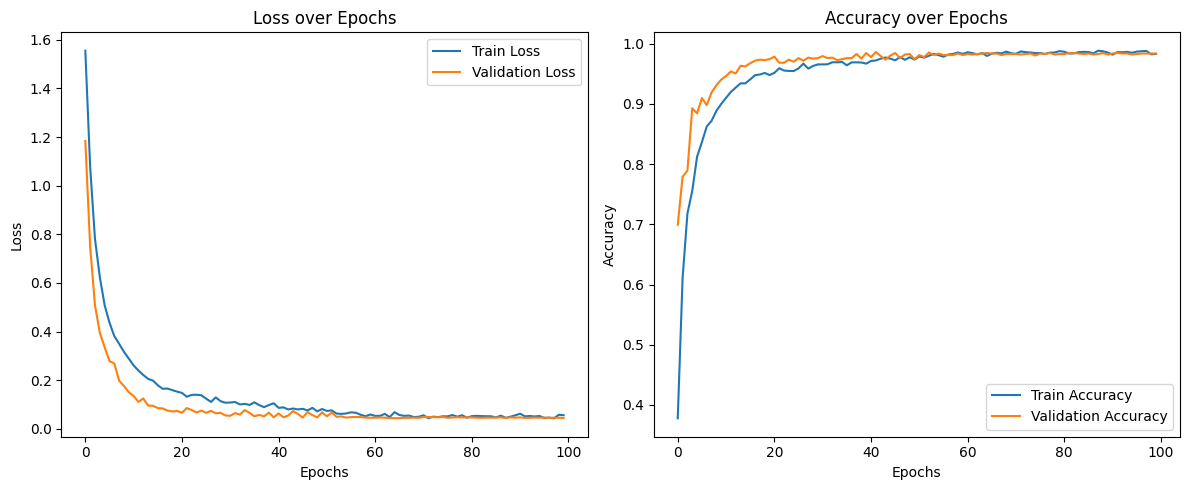

In [388]:
def best_SGD_main():
    data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
    save_path = os.path.join(os.getcwd(), 'model/best_RMSMLP_model.pth')

    data_processor = BestDataLoaderPreprocessor(data_path)
    X_train_NN, X_val_NN, y_train_NN, y_val_NN = data_processor.load_and_preprocess_data()

    train_NN_loader, valid_NN_loader = data_processor.convert_to_tensor(X_train_NN, y_train_NN, X_val_NN, y_val_NN)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    BestMLPSGD_model = BestMLP(input_dim=X_train_NN.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(BestMLP_model.parameters(), lr=1e-4, weight_decay=1e-4)
    optimizer = optim.SGD(BestMLPSGD_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    optimizer_RMS = torch.optim.RMSprop(BestMLPSGD_model.parameters(), 
                                lr=0.001,         # 기본 학습률
                                alpha=0.99,       # EMA의 감쇠율
                                eps=1e-8,         # 0으로 나누는 문제 방지
                                weight_decay=1e-4 # 가중치 정규화 (L2 정규화)
                               )

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    trainer = BestSGDTrainer(BestMLPSGD_model, criterion, optimizer, device, scheduler, save_path=save_path)

    num_epochs = 100
    trainer.train(train_NN_loader, valid_NN_loader, num_epochs)
    trainer.plot_metrics()

if __name__ == "__main__":
    best_SGD_main()

In [377]:
os.path.join(os.getcwd(), 'model/best_SGDMLP_model.pth')
os.path.join(os.getcwd(), 'model/best_RMSMLP_model.pth')

'/Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_RMSMLP_model.pth'

In [387]:
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

NN_test = pd.read_csv(test_path)
X_test_NN = NN_test.drop(['subject', 'Activity'], axis=1)

input_dim = X_test_NN.shape[1]
pretrained_MLP = BestMLP(input_dim=input_dim)

tester = BestTester(pretrained_MLP, test_path, scaler, device, best_model_path=os.path.join(os.getcwd(), 'model/best_RMSMLP_model.pth'))
tester.test()

Loaded best model from /Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_RMSMLP_model.pth
Test Accuracy: 0.9830


0.9830047586675731

## Best 1DCNN

In [356]:
class CNNDataLoaderPreprocessor:
    def __init__(self, file_path, scaler):
        self.file_path = file_path
        self.scaler = scaler

    def load_and_preprocess_data(self):
        NN_data = pd.read_csv(self.file_path)
        NN_data = NN_data.drop('subject', axis=1)
        
        NN_data['Activity'] = NN_data['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_NN = NN_data.drop('Activity', axis=1).to_numpy()
        y_NN = NN_data['Activity']

        # X_NN = self.scaler.fit_transform(X_NN)

        X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(
            X_NN, y_NN, test_size=0.2, random_state=42, stratify=y_NN)

        return X_train_NN, X_val_NN, y_train_NN, y_val_NN

    def convert_to_tensor(self, X_train_NN, y_train_NN, X_val_NN, y_val_NN):
        X_train_NN_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
        y_train_NN_tensor = torch.tensor(y_train_NN.values, dtype=torch.float32)
        X_val_NN_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
        y_val_NN_tensor = torch.tensor(y_val_NN.values, dtype=torch.float32)

        train_NN_dataset = TensorDataset(X_train_NN_tensor, y_train_NN_tensor)
        valid_NN_dataset = TensorDataset(X_val_NN_tensor, y_val_NN_tensor)
        train_NN_loader = DataLoader(train_NN_dataset, batch_size=32, shuffle=True)
        valid_NN_loader = DataLoader(valid_NN_dataset, batch_size=32, shuffle=False)

        return train_NN_loader, valid_NN_loader
    

class CNNTrainer:
    def __init__(self, model, criterion, optimizer, num_epochs, device, scheduler, save_path='best_model.pth'):
        self.model = model
        self.device = device
        self.num_epochs = num_epochs
        self.scheduler = scheduler
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        self.best_accuracy = 0  # 최적 성능 기록
        self.save_path = save_path  # 모델 저장 경로

    def scaler_train(self, train_NN_loader, valid_NN_loader):
        self.model.to(self.device)

        for epoch in range(self.num_epochs):
            # print(f"Epoch {epoch+1}/{self.num_epochs} START") 
            self.model.train()
            running_loss = 0
            correct_train = 0
            total_train = 0

            with tqdm(total=len(train_NN_loader), desc=f'Epoch {epoch+1}/{self.num_epochs}', unit='batch') as pbar:
                for batch_X, batch_y in train_NN_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    self.optimizer.zero_grad()

                    # 모델에 입력값을 전달하여 예측값 계산 (softmax 없이 logits 사용)
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)  # CrossEntropyLoss는 logits를 기대

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    
                    # argmax로 예측 클래스 계산
                    predicted = torch.argmax(outputs, dim=1)
                    total_train += batch_y.size(0)
                    correct_train += (predicted == batch_y).sum().item()

                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)
    
            self.scheduler.step()

            epoch_train_loss = running_loss / len(train_NN_loader)
            train_accuracy = correct_train / total_train
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(train_accuracy)

            # 평가 및 best model 저장
            self.evaluate_and_save_best(valid_NN_loader, epoch)

    def evaluate_and_save_best(self, valid_NN_loader, epoch):
        self.model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_X, batch_y in valid_NN_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                # 모델에 입력값을 전달하여 예측값 계산
                outputs = self.model(batch_X)
                valid_loss += self.criterion(outputs, batch_y).item()
                
                # argmax로 예측 클래스 계산
                predicted = torch.argmax(outputs, dim=1)
                total_valid += batch_y.size(0)
                correct_valid += (predicted == batch_y).sum().item()

        epoch_valid_loss = valid_loss / len(valid_NN_loader)
        valid_accuracy = correct_valid / total_valid
        self.valid_losses.append(epoch_valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}], Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

        # 최고 검증 정확도 갱신 시 모델 저장
        if valid_accuracy > self.best_accuracy:
            self.best_accuracy = valid_accuracy
            self.save_model()

    def save_model(self):
        """최고 성능을 기록한 모델을 저장"""
        torch.save(self.model.state_dict(), self.save_path)
        print(f"Best model saved with accuracy: {self.best_accuracy:.4f}")

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

Epoch 1/100: 100%|██████████| 147/147 [00:08<00:00, 17.85batch/s, loss=0.494]


Epoch [1], Validation Loss: 0.7980, Validation Accuracy: 0.7043
Best model saved with accuracy: 0.7043


Epoch 2/100: 100%|██████████| 147/147 [00:07<00:00, 20.99batch/s, loss=0.341]


Epoch [2], Validation Loss: 0.4362, Validation Accuracy: 0.8955
Best model saved with accuracy: 0.8955


Epoch 3/100: 100%|██████████| 147/147 [00:06<00:00, 21.30batch/s, loss=0.386]


Epoch [3], Validation Loss: 0.2885, Validation Accuracy: 0.9380
Best model saved with accuracy: 0.9380


Epoch 4/100: 100%|██████████| 147/147 [00:06<00:00, 23.30batch/s, loss=0.199]


Epoch [4], Validation Loss: 0.2093, Validation Accuracy: 0.9558
Best model saved with accuracy: 0.9558


Epoch 5/100: 100%|██████████| 147/147 [00:06<00:00, 22.36batch/s, loss=0.245]


Epoch [5], Validation Loss: 0.1668, Validation Accuracy: 0.9584
Best model saved with accuracy: 0.9584


Epoch 6/100: 100%|██████████| 147/147 [00:06<00:00, 24.12batch/s, loss=0.197] 


Epoch [6], Validation Loss: 0.1520, Validation Accuracy: 0.9601
Best model saved with accuracy: 0.9601


Epoch 7/100: 100%|██████████| 147/147 [00:06<00:00, 23.83batch/s, loss=0.165] 


Epoch [7], Validation Loss: 0.1196, Validation Accuracy: 0.9669
Best model saved with accuracy: 0.9669


Epoch 8/100: 100%|██████████| 147/147 [00:06<00:00, 23.44batch/s, loss=0.225] 


Epoch [8], Validation Loss: 0.1003, Validation Accuracy: 0.9720
Best model saved with accuracy: 0.9720


Epoch 9/100: 100%|██████████| 147/147 [00:06<00:00, 21.98batch/s, loss=0.205] 


Epoch [9], Validation Loss: 0.0896, Validation Accuracy: 0.9737
Best model saved with accuracy: 0.9737


Epoch 10/100: 100%|██████████| 147/147 [00:06<00:00, 22.44batch/s, loss=0.203] 


Epoch [10], Validation Loss: 0.0819, Validation Accuracy: 0.9762
Best model saved with accuracy: 0.9762


Epoch 11/100: 100%|██████████| 147/147 [00:06<00:00, 22.74batch/s, loss=0.142] 


Epoch [11], Validation Loss: 0.0872, Validation Accuracy: 0.9745


Epoch 12/100: 100%|██████████| 147/147 [00:06<00:00, 22.09batch/s, loss=0.281] 


Epoch [12], Validation Loss: 0.0845, Validation Accuracy: 0.9711


Epoch 13/100: 100%|██████████| 147/147 [00:06<00:00, 22.20batch/s, loss=0.109] 


Epoch [13], Validation Loss: 0.0797, Validation Accuracy: 0.9720


Epoch 14/100: 100%|██████████| 147/147 [00:07<00:00, 20.24batch/s, loss=0.108] 


Epoch [14], Validation Loss: 0.0772, Validation Accuracy: 0.9728


Epoch 15/100: 100%|██████████| 147/147 [00:07<00:00, 20.49batch/s, loss=0.115] 


Epoch [15], Validation Loss: 0.0635, Validation Accuracy: 0.9796
Best model saved with accuracy: 0.9796


Epoch 16/100: 100%|██████████| 147/147 [00:06<00:00, 22.27batch/s, loss=0.0587]


Epoch [16], Validation Loss: 0.0574, Validation Accuracy: 0.9830
Best model saved with accuracy: 0.9830


Epoch 17/100: 100%|██████████| 147/147 [00:07<00:00, 20.65batch/s, loss=0.254] 


Epoch [17], Validation Loss: 0.0548, Validation Accuracy: 0.9830


Epoch 18/100: 100%|██████████| 147/147 [00:06<00:00, 21.54batch/s, loss=0.0343]


Epoch [18], Validation Loss: 0.0549, Validation Accuracy: 0.9830


Epoch 19/100: 100%|██████████| 147/147 [00:05<00:00, 24.58batch/s, loss=0.0243]


Epoch [19], Validation Loss: 0.0506, Validation Accuracy: 0.9830


Epoch 20/100: 100%|██████████| 147/147 [00:06<00:00, 21.91batch/s, loss=0.0525]


Epoch [20], Validation Loss: 0.0598, Validation Accuracy: 0.9796


Epoch 21/100: 100%|██████████| 147/147 [00:07<00:00, 20.91batch/s, loss=0.0878]


Epoch [21], Validation Loss: 0.0527, Validation Accuracy: 0.9856
Best model saved with accuracy: 0.9856


Epoch 22/100: 100%|██████████| 147/147 [00:07<00:00, 20.71batch/s, loss=0.0561]


Epoch [22], Validation Loss: 0.0478, Validation Accuracy: 0.9856


Epoch 23/100: 100%|██████████| 147/147 [00:06<00:00, 22.34batch/s, loss=0.119] 


Epoch [23], Validation Loss: 0.0504, Validation Accuracy: 0.9847


Epoch 24/100: 100%|██████████| 147/147 [00:06<00:00, 22.53batch/s, loss=0.0858]


Epoch [24], Validation Loss: 0.0510, Validation Accuracy: 0.9847


Epoch 25/100: 100%|██████████| 147/147 [00:06<00:00, 22.33batch/s, loss=0.0643]


Epoch [25], Validation Loss: 0.0459, Validation Accuracy: 0.9839


Epoch 26/100: 100%|██████████| 147/147 [00:06<00:00, 22.77batch/s, loss=0.0209] 


Epoch [26], Validation Loss: 0.0474, Validation Accuracy: 0.9847


Epoch 27/100: 100%|██████████| 147/147 [00:06<00:00, 23.64batch/s, loss=0.104] 


Epoch [27], Validation Loss: 0.0444, Validation Accuracy: 0.9847


Epoch 28/100: 100%|██████████| 147/147 [00:06<00:00, 22.36batch/s, loss=0.03]  


Epoch [28], Validation Loss: 0.0390, Validation Accuracy: 0.9881
Best model saved with accuracy: 0.9881


Epoch 29/100: 100%|██████████| 147/147 [00:06<00:00, 21.12batch/s, loss=0.0252] 


Epoch [29], Validation Loss: 0.0395, Validation Accuracy: 0.9864


Epoch 30/100: 100%|██████████| 147/147 [00:06<00:00, 22.38batch/s, loss=0.014]  


Epoch [30], Validation Loss: 0.0387, Validation Accuracy: 0.9898
Best model saved with accuracy: 0.9898


Epoch 31/100: 100%|██████████| 147/147 [00:06<00:00, 22.61batch/s, loss=0.0665]


Epoch [31], Validation Loss: 0.0422, Validation Accuracy: 0.9873


Epoch 32/100: 100%|██████████| 147/147 [00:06<00:00, 22.86batch/s, loss=0.0813] 


Epoch [32], Validation Loss: 0.0471, Validation Accuracy: 0.9822


Epoch 33/100: 100%|██████████| 147/147 [00:06<00:00, 23.09batch/s, loss=0.0266] 


Epoch [33], Validation Loss: 0.0370, Validation Accuracy: 0.9898


Epoch 34/100: 100%|██████████| 147/147 [00:06<00:00, 22.55batch/s, loss=0.0224]


Epoch [34], Validation Loss: 0.0455, Validation Accuracy: 0.9856


Epoch 35/100: 100%|██████████| 147/147 [00:06<00:00, 23.51batch/s, loss=0.0263] 


Epoch [35], Validation Loss: 0.0424, Validation Accuracy: 0.9864


Epoch 36/100: 100%|██████████| 147/147 [00:06<00:00, 23.65batch/s, loss=0.0264] 


Epoch [36], Validation Loss: 0.0456, Validation Accuracy: 0.9839


Epoch 37/100: 100%|██████████| 147/147 [00:06<00:00, 24.05batch/s, loss=0.0522] 


Epoch [37], Validation Loss: 0.0375, Validation Accuracy: 0.9890


Epoch 38/100: 100%|██████████| 147/147 [00:06<00:00, 24.40batch/s, loss=0.0302] 


Epoch [38], Validation Loss: 0.0459, Validation Accuracy: 0.9856


Epoch 39/100: 100%|██████████| 147/147 [00:06<00:00, 21.59batch/s, loss=0.161]  


Epoch [39], Validation Loss: 0.0390, Validation Accuracy: 0.9873


Epoch 40/100: 100%|██████████| 147/147 [00:06<00:00, 22.70batch/s, loss=0.0521] 


Epoch [40], Validation Loss: 0.0421, Validation Accuracy: 0.9856


Epoch 41/100: 100%|██████████| 147/147 [00:06<00:00, 21.16batch/s, loss=0.0996] 


Epoch [41], Validation Loss: 0.0392, Validation Accuracy: 0.9864


Epoch 42/100: 100%|██████████| 147/147 [00:06<00:00, 23.05batch/s, loss=0.0609] 


Epoch [42], Validation Loss: 0.0376, Validation Accuracy: 0.9873


Epoch 43/100: 100%|██████████| 147/147 [00:06<00:00, 23.50batch/s, loss=0.163]  


Epoch [43], Validation Loss: 0.0443, Validation Accuracy: 0.9839


Epoch 44/100: 100%|██████████| 147/147 [00:05<00:00, 24.80batch/s, loss=0.0118] 


Epoch [44], Validation Loss: 0.0406, Validation Accuracy: 0.9856


Epoch 45/100: 100%|██████████| 147/147 [00:06<00:00, 23.34batch/s, loss=0.0493] 


Epoch [45], Validation Loss: 0.0423, Validation Accuracy: 0.9856


Epoch 46/100: 100%|██████████| 147/147 [00:05<00:00, 25.48batch/s, loss=0.0553] 


Epoch [46], Validation Loss: 0.0362, Validation Accuracy: 0.9873


Epoch 47/100: 100%|██████████| 147/147 [00:05<00:00, 24.95batch/s, loss=0.0136] 


Epoch [47], Validation Loss: 0.0328, Validation Accuracy: 0.9881


Epoch 48/100: 100%|██████████| 147/147 [00:05<00:00, 24.50batch/s, loss=0.0212] 


Epoch [48], Validation Loss: 0.0345, Validation Accuracy: 0.9890


Epoch 49/100: 100%|██████████| 147/147 [00:05<00:00, 25.44batch/s, loss=0.0287] 


Epoch [49], Validation Loss: 0.0323, Validation Accuracy: 0.9898


Epoch 50/100: 100%|██████████| 147/147 [00:05<00:00, 24.65batch/s, loss=0.0407] 


Epoch [50], Validation Loss: 0.0396, Validation Accuracy: 0.9864


Epoch 51/100: 100%|██████████| 147/147 [00:05<00:00, 24.55batch/s, loss=0.00447]


Epoch [51], Validation Loss: 0.0327, Validation Accuracy: 0.9873


Epoch 52/100: 100%|██████████| 147/147 [00:06<00:00, 23.70batch/s, loss=0.0328] 


Epoch [52], Validation Loss: 0.0377, Validation Accuracy: 0.9873


Epoch 53/100: 100%|██████████| 147/147 [00:06<00:00, 24.04batch/s, loss=0.0329] 


Epoch [53], Validation Loss: 0.0305, Validation Accuracy: 0.9907
Best model saved with accuracy: 0.9907


Epoch 54/100: 100%|██████████| 147/147 [00:06<00:00, 24.30batch/s, loss=0.0835] 


Epoch [54], Validation Loss: 0.0322, Validation Accuracy: 0.9898


Epoch 55/100: 100%|██████████| 147/147 [00:06<00:00, 23.98batch/s, loss=0.0402] 


Epoch [55], Validation Loss: 0.0339, Validation Accuracy: 0.9873


Epoch 56/100: 100%|██████████| 147/147 [00:05<00:00, 24.59batch/s, loss=0.0158] 


Epoch [56], Validation Loss: 0.0337, Validation Accuracy: 0.9873


Epoch 57/100: 100%|██████████| 147/147 [00:05<00:00, 24.91batch/s, loss=0.0809] 


Epoch [57], Validation Loss: 0.0313, Validation Accuracy: 0.9898


Epoch 58/100: 100%|██████████| 147/147 [00:05<00:00, 25.06batch/s, loss=0.0421] 


Epoch [58], Validation Loss: 0.0335, Validation Accuracy: 0.9864


Epoch 59/100: 100%|██████████| 147/147 [00:05<00:00, 24.60batch/s, loss=0.00694]


Epoch [59], Validation Loss: 0.0335, Validation Accuracy: 0.9847


Epoch 60/100: 100%|██████████| 147/147 [00:05<00:00, 25.08batch/s, loss=0.0142] 


Epoch [60], Validation Loss: 0.0405, Validation Accuracy: 0.9839


Epoch 61/100: 100%|██████████| 147/147 [00:05<00:00, 25.63batch/s, loss=0.00907] 


Epoch [61], Validation Loss: 0.0297, Validation Accuracy: 0.9898


Epoch 62/100: 100%|██████████| 147/147 [00:05<00:00, 25.22batch/s, loss=0.0207] 


Epoch [62], Validation Loss: 0.0281, Validation Accuracy: 0.9907


Epoch 63/100: 100%|██████████| 147/147 [00:05<00:00, 24.78batch/s, loss=0.00784]


Epoch [63], Validation Loss: 0.0299, Validation Accuracy: 0.9898


Epoch 64/100: 100%|██████████| 147/147 [00:05<00:00, 25.56batch/s, loss=0.0082]  


Epoch [64], Validation Loss: 0.0316, Validation Accuracy: 0.9881


Epoch 65/100: 100%|██████████| 147/147 [00:05<00:00, 25.44batch/s, loss=0.0949] 


Epoch [65], Validation Loss: 0.0266, Validation Accuracy: 0.9907


Epoch 66/100: 100%|██████████| 147/147 [00:06<00:00, 22.83batch/s, loss=0.0586] 


Epoch [66], Validation Loss: 0.0372, Validation Accuracy: 0.9864


Epoch 67/100: 100%|██████████| 147/147 [00:06<00:00, 24.33batch/s, loss=0.0198] 


Epoch [67], Validation Loss: 0.0360, Validation Accuracy: 0.9873


Epoch 68/100: 100%|██████████| 147/147 [00:06<00:00, 22.60batch/s, loss=0.0118] 


Epoch [68], Validation Loss: 0.0297, Validation Accuracy: 0.9890


Epoch 69/100: 100%|██████████| 147/147 [00:07<00:00, 20.60batch/s, loss=0.0133] 


Epoch [69], Validation Loss: 0.0320, Validation Accuracy: 0.9873


Epoch 70/100: 100%|██████████| 147/147 [00:06<00:00, 21.36batch/s, loss=0.0204] 


Epoch [70], Validation Loss: 0.0290, Validation Accuracy: 0.9890


Epoch 71/100: 100%|██████████| 147/147 [00:06<00:00, 21.11batch/s, loss=0.022]   


Epoch [71], Validation Loss: 0.0295, Validation Accuracy: 0.9898


Epoch 72/100: 100%|██████████| 147/147 [00:06<00:00, 21.93batch/s, loss=0.00396]


Epoch [72], Validation Loss: 0.0337, Validation Accuracy: 0.9890


Epoch 73/100: 100%|██████████| 147/147 [00:07<00:00, 20.67batch/s, loss=0.00822]


Epoch [73], Validation Loss: 0.0286, Validation Accuracy: 0.9915
Best model saved with accuracy: 0.9915


Epoch 74/100: 100%|██████████| 147/147 [00:06<00:00, 21.37batch/s, loss=0.00516]


Epoch [74], Validation Loss: 0.0333, Validation Accuracy: 0.9873


Epoch 75/100: 100%|██████████| 147/147 [00:06<00:00, 23.46batch/s, loss=0.0177]  


Epoch [75], Validation Loss: 0.0388, Validation Accuracy: 0.9856


Epoch 76/100: 100%|██████████| 147/147 [00:06<00:00, 23.84batch/s, loss=0.0314]  


Epoch [76], Validation Loss: 0.0321, Validation Accuracy: 0.9881


Epoch 77/100: 100%|██████████| 147/147 [00:05<00:00, 25.16batch/s, loss=0.00593]


Epoch [77], Validation Loss: 0.0327, Validation Accuracy: 0.9873


Epoch 78/100: 100%|██████████| 147/147 [00:05<00:00, 24.99batch/s, loss=0.0222] 


Epoch [78], Validation Loss: 0.0294, Validation Accuracy: 0.9915


Epoch 79/100: 100%|██████████| 147/147 [00:06<00:00, 24.35batch/s, loss=0.00396]


Epoch [79], Validation Loss: 0.0308, Validation Accuracy: 0.9890


Epoch 80/100: 100%|██████████| 147/147 [00:05<00:00, 24.83batch/s, loss=0.0507] 


Epoch [80], Validation Loss: 0.0271, Validation Accuracy: 0.9907


Epoch 81/100: 100%|██████████| 147/147 [00:06<00:00, 24.48batch/s, loss=0.00946]


Epoch [81], Validation Loss: 0.0299, Validation Accuracy: 0.9890


Epoch 82/100: 100%|██████████| 147/147 [00:05<00:00, 24.80batch/s, loss=0.0195] 


Epoch [82], Validation Loss: 0.0296, Validation Accuracy: 0.9890


Epoch 83/100: 100%|██████████| 147/147 [00:05<00:00, 25.19batch/s, loss=0.0547] 


Epoch [83], Validation Loss: 0.0355, Validation Accuracy: 0.9881


Epoch 84/100: 100%|██████████| 147/147 [00:05<00:00, 25.24batch/s, loss=0.0243] 


Epoch [84], Validation Loss: 0.0293, Validation Accuracy: 0.9890


Epoch 85/100: 100%|██████████| 147/147 [00:06<00:00, 23.74batch/s, loss=0.0105] 


Epoch [85], Validation Loss: 0.0296, Validation Accuracy: 0.9898


Epoch 86/100: 100%|██████████| 147/147 [00:05<00:00, 25.29batch/s, loss=0.111]  


Epoch [86], Validation Loss: 0.0334, Validation Accuracy: 0.9873


Epoch 87/100: 100%|██████████| 147/147 [00:05<00:00, 25.32batch/s, loss=0.00793]


Epoch [87], Validation Loss: 0.0290, Validation Accuracy: 0.9907


Epoch 88/100: 100%|██████████| 147/147 [00:05<00:00, 24.73batch/s, loss=0.012]  


Epoch [88], Validation Loss: 0.0298, Validation Accuracy: 0.9907


Epoch 89/100: 100%|██████████| 147/147 [00:05<00:00, 24.73batch/s, loss=0.00743]


Epoch [89], Validation Loss: 0.0290, Validation Accuracy: 0.9907


Epoch 90/100: 100%|██████████| 147/147 [00:05<00:00, 25.33batch/s, loss=0.0101] 


Epoch [90], Validation Loss: 0.0270, Validation Accuracy: 0.9898


Epoch 91/100: 100%|██████████| 147/147 [00:05<00:00, 25.22batch/s, loss=0.0233] 


Epoch [91], Validation Loss: 0.0291, Validation Accuracy: 0.9890


Epoch 92/100: 100%|██████████| 147/147 [00:05<00:00, 24.68batch/s, loss=0.0678]  


Epoch [92], Validation Loss: 0.0255, Validation Accuracy: 0.9915


Epoch 93/100: 100%|██████████| 147/147 [00:05<00:00, 25.17batch/s, loss=0.0601] 


Epoch [93], Validation Loss: 0.0307, Validation Accuracy: 0.9890


Epoch 94/100: 100%|██████████| 147/147 [00:05<00:00, 25.29batch/s, loss=0.0135]  


Epoch [94], Validation Loss: 0.0286, Validation Accuracy: 0.9915


Epoch 95/100: 100%|██████████| 147/147 [00:05<00:00, 24.71batch/s, loss=0.0949]  


Epoch [95], Validation Loss: 0.0268, Validation Accuracy: 0.9915


Epoch 96/100: 100%|██████████| 147/147 [00:06<00:00, 24.10batch/s, loss=0.00293] 


Epoch [96], Validation Loss: 0.0237, Validation Accuracy: 0.9932
Best model saved with accuracy: 0.9932


Epoch 97/100: 100%|██████████| 147/147 [00:05<00:00, 24.58batch/s, loss=0.00332] 


Epoch [97], Validation Loss: 0.0249, Validation Accuracy: 0.9915


Epoch 98/100: 100%|██████████| 147/147 [00:06<00:00, 24.32batch/s, loss=0.0391]  


Epoch [98], Validation Loss: 0.0288, Validation Accuracy: 0.9907


Epoch 99/100: 100%|██████████| 147/147 [00:06<00:00, 24.42batch/s, loss=0.00167] 


Epoch [99], Validation Loss: 0.0337, Validation Accuracy: 0.9881


Epoch 100/100: 100%|██████████| 147/147 [00:05<00:00, 25.16batch/s, loss=0.00657]


Epoch [100], Validation Loss: 0.0263, Validation Accuracy: 0.9915


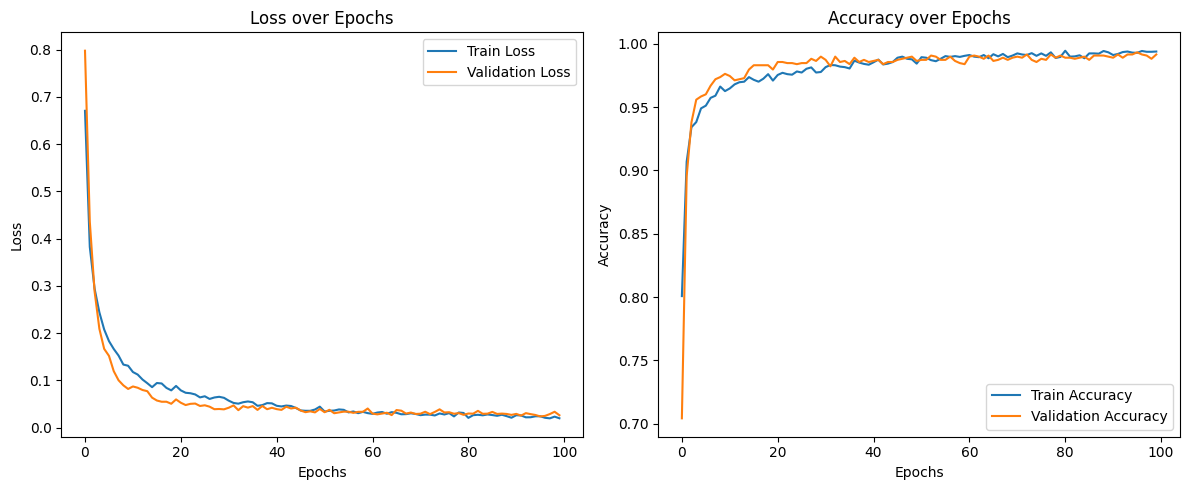

In [390]:
def CNN_main():
    data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
    save_path = os.path.join(os.getcwd(), 'model/best_scaled_CNN.pth')

    data_processor = CNNDataLoaderPreprocessor(data_path, CNN_scaler)
    X_train_NN, X_val_NN, y_train_NN, y_val_NN = data_processor.load_and_preprocess_data()

    train_NN_loader, valid_NN_loader = data_processor.convert_to_tensor(X_train_NN, y_train_NN, X_val_NN, y_val_NN)

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
    CNN_model = CNN1D(input_dim=X_train_NN.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-4, weight_decay=1e-4)
    # optimizer = optim.SGD(CNN_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    num_epochs = 100
    T_max = num_epochs // 3  # 33 epochs
    eta_min = 1e-6
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    trainer = CNNTrainer(model=CNN_model, criterion=criterion, 
                            optimizer=optimizer, num_epochs=num_epochs,
                            device=device, scheduler=scheduler, save_path=save_path
                            )
    trainer.scaler_train(train_NN_loader, valid_NN_loader)
    trainer.plot_metrics()

if __name__ == "__main__":
    CNN_main()

In [392]:
class CNNSTester:
    def __init__(self, model, test_path, scaler, device, best_model_path='best_model.pth'):
        self.model = model
        self.test_path = test_path
        self.scaler = scaler
        self.device = device
        self.best_model_path = best_model_path  # 최적 모델 경로
        self.model.to(self.device)

    def load_and_preprocess_data(self):
        # 테스트 데이터를 로드하고 전처리 수행
        NN_test = pd.read_csv(self.test_path)
        NN_test = NN_test.drop('subject', axis=1)  # 'subject' 열 제거
        NN_test['Activity'] = NN_test['Activity'].map({
            'WALKING': 0,
            'WALKING_UPSTAIRS': 1,
            'WALKING_DOWNSTAIRS': 2,
            'LAYING': 3,
            'STANDING': 4,
            'SITTING': 5
        })

        X_test_NN = NN_test.drop(['Activity'], axis=1).to_numpy()
        y_test_NN = NN_test['Activity']

        # Tensor 변환 후 GPU로 전달
        X_test_NN_tensor = torch.tensor(X_test_NN, dtype=torch.float32).to(self.device)
        y_test_NN_tensor = torch.tensor(y_test_NN.values, dtype=torch.long).to(self.device)

        return X_test_NN_tensor, y_test_NN_tensor

    def load_best_model(self):
        """저장된 최적의 모델을 로드"""
        self.model.load_state_dict(torch.load(self.best_model_path))
        print(f'Loaded best model from {self.best_model_path}')

    def test(self):
        """테스트 데이터로 모델 성능 평가"""
        # 최적의 모델 불러오기
        self.load_best_model()

        # 모델 평가 모드로 전환
        self.model.eval()

        # 테스트 데이터를 로드하고 전처리
        X_test_NN_tensor, y_test_NN_tensor = self.load_and_preprocess_data()

        # 예측 및 정확도 계산
        with torch.no_grad():
            # 모델로 예측값 계산 (softmax 사용 안 함)
            outputs = self.model(X_test_NN_tensor).squeeze()

            # argmax를 통해 가장 높은 값을 예측된 클래스로 추출
            predicted = torch.argmax(outputs, dim=1)

            # 예측값과 실제값 비교하여 정확도 계산
            correct = (predicted == y_test_NN_tensor).sum().item()
            total = y_test_NN_tensor.size(0)

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
        return accuracy
    
test_path = os.path.join(os.getcwd(), 'data/data01_test.csv')

NN_test = pd.read_csv(test_path)
X_test_NN = NN_test.drop(['subject', 'Activity'], axis=1)

input_dim = X_test_NN.shape[1]
pretrained_MLP = CNN1D(input_dim=input_dim)

tester = CNNSTester(pretrained_MLP, test_path, CNN_scaler, device, best_model_path=os.path.join(os.getcwd(), 'model/best_scaled_CNN.pth'))
tester.test()


Loaded best model from /Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/model/best_scaled_CNN.pth
Test Accuracy: 0.9925


0.9925220938137321